<a href="https://colab.research.google.com/github/LIYunzhe1408/Facial-Keypoint-Detection/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [ ]:
# Fetch data
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

mkdir: cannot create directory ‘data’: File exists
--2025-04-15 09:48:07--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.8.6, 52.217.167.216, 54.231.223.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.8.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘data/train-test-data.zip.6’

train-test-data.zip 100%[===================>] 322.93M  66.6MB/s    in 4.8s    

2025-04-15 09:48:12 (67.2 MB/s) - ‘data/train-test-data.zip.6’ saved [338613624/338613624]

Archive:  data/train-test-data.zip


# Setup Environment

In [ ]:
# No need if you are using colab

# !pip install matplotlib~=3.5.2
# !pip install scikit-image==0.19.2
# !pip install torch~=1.8.1
# !pip install torchvision~=0.9.1
# !pip install numpy~=1.21.6
# !pip install pillow~=9.1.1
# !pip install tqdm~=4.64.0
# !pip install jupyter==1.0.0
# !pip install opencv-python==4.6.0.66
# !pip install pandas==1.3.5


## Prep - Visualize the data

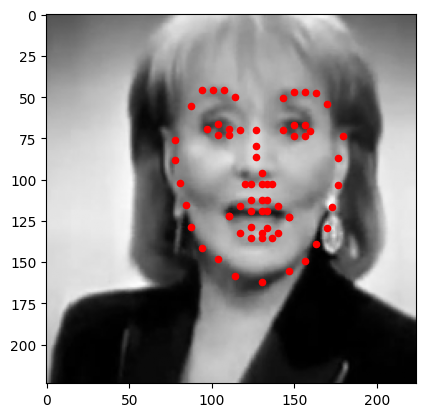

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image black and white
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    plt.show()
    break


## Part1-SimpleNet
Find best hyperparameters
* Loss Function
* Learning Rate
* Optimizer
* Dropout Layer weights

In [ ]:
from models import SimpleNet
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    early_stop_cnt = 0

    net.train()
    net.cuda()
    best_val_loss = float("inf")

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}_best.pth"

        if epoch in [9, 19, 149, 299]:
            torch.save(net.state_dict(), f"./models/{model_name}_epoch_{epoch}.pth")
            print(f"Saved model (Val Loss: {epoch_val_loss:.4f})")

        if epoch_val_loss < best_val_loss:
            early_stop_cnt = 0
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# ===================================
# Part 1 Net
# Loss Function
# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()

# net_batch_64 = SimpleNet()
# net_LR_05 = SimpleNet()
# net_LR_00005 = SimpleNet()

# net_AdamW = SimpleNet()
# net_dropout_all_02 = SimpleNet()


# ========== HYPERPARAMETERS ==========
# n_epochs = 10
# optimizer_smoothL1 = optim.Adam(net_LR_00005.parameters(), lr=0.0005)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)
# optimizer = optim.AdamW(net_dropout_all_02.parameters(), lr=5e-4)


# ========== TRAIN MODELS ==========
# Loss Function
# SmoothL1_losses, val_SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)
# MSE_losses, val_MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE, test_loader)

# Batch Size
# LR_05_L1_loss, LR_05_L1_val_loss = train_net(net_LR_00005, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)

# AdamW_loss, AdamW_val_loss = train_net(net_AdamW, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

# droupout_all_02_loss, droupout_all_02_val_loss = train_net(net_dropout_all_02, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

n_epochs = 300
net_best_hyper = SimpleNet()
optimizer = optim.AdamW(net_best_hyper.parameters(), lr=0.0005)
criterion = nn.SmoothL1Loss()
train_losses, val_losses = train_net(net_best_hyper, n_epochs, criterion, optimizer, test_loader, "simpleNet")


training:   0%|          | 1/300 [00:05<25:03,  5.03s/it]

Saved best model (Val Loss: 0.0900)
Epoch 1/300 | Train Loss: 0.2423 | Val Loss: 0.0900



training:   1%|          | 2/300 [00:09<24:29,  4.93s/it]

Saved best model (Val Loss: 0.0706)
Epoch 2/300 | Train Loss: 0.0796 | Val Loss: 0.0706



training:   1%|          | 3/300 [00:14<23:49,  4.81s/it]

Saved best model (Val Loss: 0.0603)
Epoch 3/300 | Train Loss: 0.0712 | Val Loss: 0.0603



training:   1%|▏         | 4/300 [00:19<23:04,  4.68s/it]

Epoch 4/300 | Train Loss: 0.0722 | Val Loss: 0.0640



training:   2%|▏         | 5/300 [00:23<22:26,  4.56s/it]

Epoch 5/300 | Train Loss: 0.0682 | Val Loss: 0.0637



training:   2%|▏         | 6/300 [00:28<22:33,  4.60s/it]

Saved best model (Val Loss: 0.0530)
Epoch 6/300 | Train Loss: 0.0676 | Val Loss: 0.0530



training:   2%|▏         | 7/300 [00:32<22:15,  4.56s/it]

Epoch 7/300 | Train Loss: 0.0655 | Val Loss: 0.0577



training:   3%|▎         | 8/300 [00:37<22:23,  4.60s/it]

Saved best model (Val Loss: 0.0483)
Epoch 8/300 | Train Loss: 0.0592 | Val Loss: 0.0483



training:   3%|▎         | 9/300 [00:41<21:55,  4.52s/it]

Epoch 9/300 | Train Loss: 0.0546 | Val Loss: 0.0484



epoch 9: 100%|██████████| 109/109 [00:03<00:00, 32.48it/s]


Saved model (Val Loss: 0.0401)


training:   3%|▎         | 10/300 [00:46<22:28,  4.65s/it]

Saved best model (Val Loss: 0.0401)
Epoch 10/300 | Train Loss: 0.0498 | Val Loss: 0.0401



training:   4%|▎         | 11/300 [00:51<22:30,  4.67s/it]

Saved best model (Val Loss: 0.0323)
Epoch 11/300 | Train Loss: 0.0405 | Val Loss: 0.0323



training:   4%|▍         | 12/300 [00:56<22:40,  4.72s/it]

Saved best model (Val Loss: 0.0246)
Epoch 12/300 | Train Loss: 0.0358 | Val Loss: 0.0246



training:   4%|▍         | 13/300 [01:00<22:00,  4.60s/it]

Epoch 13/300 | Train Loss: 0.0317 | Val Loss: 0.0268



training:   5%|▍         | 14/300 [01:05<22:11,  4.66s/it]

Saved best model (Val Loss: 0.0228)
Epoch 14/300 | Train Loss: 0.0280 | Val Loss: 0.0228



training:   5%|▌         | 15/300 [01:09<22:11,  4.67s/it]

Saved best model (Val Loss: 0.0215)
Epoch 15/300 | Train Loss: 0.0252 | Val Loss: 0.0215



training:   5%|▌         | 16/300 [01:14<21:26,  4.53s/it]

Epoch 16/300 | Train Loss: 0.0262 | Val Loss: 0.0228



training:   6%|▌         | 17/300 [01:18<21:40,  4.60s/it]

Saved best model (Val Loss: 0.0189)
Epoch 17/300 | Train Loss: 0.0235 | Val Loss: 0.0189



training:   6%|▌         | 18/300 [01:23<21:07,  4.49s/it]

Epoch 18/300 | Train Loss: 0.0189 | Val Loss: 0.0198



training:   6%|▋         | 19/300 [01:27<21:19,  4.55s/it]

Saved best model (Val Loss: 0.0170)
Epoch 19/300 | Train Loss: 0.0173 | Val Loss: 0.0170



training:   7%|▋         | 20/300 [01:32<21:32,  4.61s/it]

Saved model (Val Loss: 0.0171)
Epoch 20/300 | Train Loss: 0.0183 | Val Loss: 0.0171



training:   7%|▋         | 21/300 [01:37<21:39,  4.66s/it]

Saved best model (Val Loss: 0.0122)
Epoch 21/300 | Train Loss: 0.0184 | Val Loss: 0.0122



training:   7%|▋         | 22/300 [01:41<21:19,  4.60s/it]

Epoch 22/300 | Train Loss: 0.0158 | Val Loss: 0.0136



training:   8%|▊         | 23/300 [01:46<20:44,  4.49s/it]

Epoch 23/300 | Train Loss: 0.0139 | Val Loss: 0.0144



training:   8%|▊         | 24/300 [01:50<20:55,  4.55s/it]

Saved best model (Val Loss: 0.0116)
Epoch 24/300 | Train Loss: 0.0153 | Val Loss: 0.0116



training:   8%|▊         | 25/300 [01:55<20:35,  4.49s/it]

Epoch 25/300 | Train Loss: 0.0133 | Val Loss: 0.0141



training:   9%|▊         | 26/300 [01:59<20:52,  4.57s/it]

Saved best model (Val Loss: 0.0101)
Epoch 26/300 | Train Loss: 0.0124 | Val Loss: 0.0101



training:   9%|▉         | 27/300 [02:04<20:31,  4.51s/it]

Epoch 27/300 | Train Loss: 0.0111 | Val Loss: 0.0134



training:   9%|▉         | 28/300 [02:08<20:15,  4.47s/it]

Epoch 28/300 | Train Loss: 0.0110 | Val Loss: 0.0118



training:  10%|▉         | 29/300 [02:12<20:09,  4.46s/it]

Epoch 29/300 | Train Loss: 0.0110 | Val Loss: 0.0140



training:  10%|█         | 30/300 [02:17<20:45,  4.61s/it]

Saved best model (Val Loss: 0.0092)
Epoch 30/300 | Train Loss: 0.0108 | Val Loss: 0.0092



training:  10%|█         | 31/300 [02:22<20:46,  4.63s/it]

Saved best model (Val Loss: 0.0082)
Epoch 31/300 | Train Loss: 0.0104 | Val Loss: 0.0082



training:  11%|█         | 32/300 [02:26<20:19,  4.55s/it]

Epoch 32/300 | Train Loss: 0.0108 | Val Loss: 0.0082



training:  11%|█         | 33/300 [02:31<19:52,  4.47s/it]

Epoch 33/300 | Train Loss: 0.0089 | Val Loss: 0.0142



training:  11%|█▏        | 34/300 [02:35<19:36,  4.42s/it]

Epoch 34/300 | Train Loss: 0.0101 | Val Loss: 0.0091



training:  12%|█▏        | 35/300 [02:40<20:13,  4.58s/it]

Saved best model (Val Loss: 0.0074)
Epoch 35/300 | Train Loss: 0.0108 | Val Loss: 0.0074



training:  12%|█▏        | 36/300 [02:44<19:48,  4.50s/it]

Epoch 36/300 | Train Loss: 0.0084 | Val Loss: 0.0118



training:  12%|█▏        | 37/300 [02:49<20:01,  4.57s/it]

Saved best model (Val Loss: 0.0071)
Epoch 37/300 | Train Loss: 0.0098 | Val Loss: 0.0071



training:  13%|█▎        | 38/300 [02:54<19:46,  4.53s/it]

Epoch 38/300 | Train Loss: 0.0075 | Val Loss: 0.0079



training:  13%|█▎        | 39/300 [02:58<19:52,  4.57s/it]

Saved best model (Val Loss: 0.0062)
Epoch 39/300 | Train Loss: 0.0072 | Val Loss: 0.0062



training:  13%|█▎        | 40/300 [03:03<19:34,  4.52s/it]

Epoch 40/300 | Train Loss: 0.0070 | Val Loss: 0.0071



training:  14%|█▎        | 41/300 [03:07<19:15,  4.46s/it]

Epoch 41/300 | Train Loss: 0.0066 | Val Loss: 0.0080



training:  14%|█▍        | 42/300 [03:11<19:09,  4.46s/it]

Epoch 42/300 | Train Loss: 0.0080 | Val Loss: 0.0074



training:  14%|█▍        | 43/300 [03:16<19:13,  4.49s/it]

Epoch 43/300 | Train Loss: 0.0082 | Val Loss: 0.0079



training:  15%|█▍        | 44/300 [03:20<19:01,  4.46s/it]

Epoch 44/300 | Train Loss: 0.0083 | Val Loss: 0.0068



training:  15%|█▌        | 45/300 [03:25<18:54,  4.45s/it]

Epoch 45/300 | Train Loss: 0.0085 | Val Loss: 0.0080



training:  15%|█▌        | 46/300 [03:29<18:43,  4.42s/it]

Epoch 46/300 | Train Loss: 0.0068 | Val Loss: 0.0064



training:  16%|█▌        | 47/300 [03:33<18:31,  4.39s/it]

Epoch 47/300 | Train Loss: 0.0076 | Val Loss: 0.0064



training:  16%|█▌        | 48/300 [03:38<18:37,  4.44s/it]

Epoch 48/300 | Train Loss: 0.0062 | Val Loss: 0.0103



training:  16%|█▋        | 49/300 [03:42<18:31,  4.43s/it]

Epoch 49/300 | Train Loss: 0.0069 | Val Loss: 0.0072



training:  17%|█▋        | 50/300 [03:47<18:20,  4.40s/it]

Epoch 50/300 | Train Loss: 0.0063 | Val Loss: 0.0078



training:  17%|█▋        | 51/300 [03:52<18:45,  4.52s/it]

Saved best model (Val Loss: 0.0057)
Epoch 51/300 | Train Loss: 0.0058 | Val Loss: 0.0057



training:  17%|█▋        | 52/300 [03:56<18:55,  4.58s/it]

Saved best model (Val Loss: 0.0056)
Epoch 52/300 | Train Loss: 0.0062 | Val Loss: 0.0056



training:  18%|█▊        | 53/300 [04:01<18:43,  4.55s/it]

Epoch 53/300 | Train Loss: 0.0068 | Val Loss: 0.0064



training:  18%|█▊        | 54/300 [04:05<18:50,  4.60s/it]

Saved best model (Val Loss: 0.0050)
Epoch 54/300 | Train Loss: 0.0062 | Val Loss: 0.0050



training:  18%|█▊        | 55/300 [04:10<18:25,  4.51s/it]

Epoch 55/300 | Train Loss: 0.0077 | Val Loss: 0.0057



training:  19%|█▊        | 56/300 [04:14<18:15,  4.49s/it]

Epoch 56/300 | Train Loss: 0.0058 | Val Loss: 0.0068



training:  19%|█▉        | 57/300 [04:18<17:55,  4.43s/it]

Epoch 57/300 | Train Loss: 0.0073 | Val Loss: 0.0077



training:  19%|█▉        | 58/300 [04:23<17:44,  4.40s/it]

Epoch 58/300 | Train Loss: 0.0066 | Val Loss: 0.0059



training:  20%|█▉        | 59/300 [04:27<17:38,  4.39s/it]

Epoch 59/300 | Train Loss: 0.0058 | Val Loss: 0.0073



training:  20%|██        | 60/300 [04:31<17:26,  4.36s/it]

Epoch 60/300 | Train Loss: 0.0073 | Val Loss: 0.0094



training:  20%|██        | 61/300 [04:36<17:29,  4.39s/it]

Epoch 61/300 | Train Loss: 0.0072 | Val Loss: 0.0086



training:  21%|██        | 62/300 [04:40<17:20,  4.37s/it]

Epoch 62/300 | Train Loss: 0.0058 | Val Loss: 0.0065



training:  21%|██        | 63/300 [04:45<17:12,  4.36s/it]

Epoch 63/300 | Train Loss: 0.0067 | Val Loss: 0.0063



training:  21%|██▏       | 64/300 [04:49<17:04,  4.34s/it]

Epoch 64/300 | Train Loss: 0.0052 | Val Loss: 0.0053



training:  22%|██▏       | 65/300 [04:53<17:00,  4.34s/it]

Epoch 65/300 | Train Loss: 0.0054 | Val Loss: 0.0070



training:  22%|██▏       | 66/300 [04:58<16:53,  4.33s/it]

Epoch 66/300 | Train Loss: 0.0054 | Val Loss: 0.0078



training:  22%|██▏       | 67/300 [05:02<16:48,  4.33s/it]

Epoch 67/300 | Train Loss: 0.0052 | Val Loss: 0.0056



training:  23%|██▎       | 68/300 [05:07<17:15,  4.46s/it]

Saved best model (Val Loss: 0.0048)
Epoch 68/300 | Train Loss: 0.0057 | Val Loss: 0.0048



training:  23%|██▎       | 69/300 [05:11<17:08,  4.45s/it]

Epoch 69/300 | Train Loss: 0.0049 | Val Loss: 0.0077



training:  23%|██▎       | 70/300 [05:15<17:00,  4.44s/it]

Epoch 70/300 | Train Loss: 0.0054 | Val Loss: 0.0053



training:  24%|██▎       | 71/300 [05:20<16:50,  4.41s/it]

Epoch 71/300 | Train Loss: 0.0053 | Val Loss: 0.0050



training:  24%|██▍       | 72/300 [05:24<16:42,  4.40s/it]

Epoch 72/300 | Train Loss: 0.0045 | Val Loss: 0.0084



training:  24%|██▍       | 73/300 [05:28<16:33,  4.38s/it]

Epoch 73/300 | Train Loss: 0.0047 | Val Loss: 0.0056



training:  25%|██▍       | 74/300 [05:33<16:32,  4.39s/it]

Epoch 74/300 | Train Loss: 0.0043 | Val Loss: 0.0058



training:  25%|██▌       | 75/300 [05:37<16:22,  4.37s/it]

Epoch 75/300 | Train Loss: 0.0043 | Val Loss: 0.0049



training:  25%|██▌       | 76/300 [05:42<16:41,  4.47s/it]

Saved best model (Val Loss: 0.0044)
Epoch 76/300 | Train Loss: 0.0043 | Val Loss: 0.0044



training:  26%|██▌       | 77/300 [05:46<16:42,  4.50s/it]

Epoch 77/300 | Train Loss: 0.0044 | Val Loss: 0.0046



training:  26%|██▌       | 78/300 [05:51<16:22,  4.42s/it]

Epoch 78/300 | Train Loss: 0.0038 | Val Loss: 0.0057



training:  26%|██▋       | 79/300 [05:55<16:12,  4.40s/it]

Epoch 79/300 | Train Loss: 0.0043 | Val Loss: 0.0049



training:  27%|██▋       | 80/300 [06:00<16:14,  4.43s/it]

Epoch 80/300 | Train Loss: 0.0044 | Val Loss: 0.0080



training:  27%|██▋       | 81/300 [06:04<16:27,  4.51s/it]

Saved best model (Val Loss: 0.0041)
Epoch 81/300 | Train Loss: 0.0042 | Val Loss: 0.0041



training:  27%|██▋       | 82/300 [06:09<16:13,  4.46s/it]

Epoch 82/300 | Train Loss: 0.0036 | Val Loss: 0.0043



training:  28%|██▊       | 83/300 [06:13<15:57,  4.41s/it]

Epoch 83/300 | Train Loss: 0.0046 | Val Loss: 0.0050



training:  28%|██▊       | 84/300 [06:17<15:47,  4.39s/it]

Epoch 84/300 | Train Loss: 0.0032 | Val Loss: 0.0068



training:  28%|██▊       | 85/300 [06:22<15:44,  4.39s/it]

Epoch 85/300 | Train Loss: 0.0045 | Val Loss: 0.0058



training:  29%|██▊       | 86/300 [06:26<15:35,  4.37s/it]

Epoch 86/300 | Train Loss: 0.0089 | Val Loss: 0.0121



training:  29%|██▉       | 87/300 [06:30<15:33,  4.38s/it]

Epoch 87/300 | Train Loss: 0.0078 | Val Loss: 0.0052



training:  29%|██▉       | 88/300 [06:35<15:28,  4.38s/it]

Epoch 88/300 | Train Loss: 0.0063 | Val Loss: 0.0058



training:  30%|██▉       | 89/300 [06:39<15:20,  4.36s/it]

Epoch 89/300 | Train Loss: 0.0053 | Val Loss: 0.0066



training:  30%|███       | 90/300 [06:44<15:25,  4.41s/it]

Epoch 90/300 | Train Loss: 0.0054 | Val Loss: 0.0067



training:  30%|███       | 91/300 [06:48<15:15,  4.38s/it]

Epoch 91/300 | Train Loss: 0.0065 | Val Loss: 0.0046



training:  31%|███       | 92/300 [06:52<15:01,  4.33s/it]

Epoch 92/300 | Train Loss: 0.0048 | Val Loss: 0.0047



training:  31%|███       | 93/300 [06:57<15:07,  4.39s/it]

Epoch 93/300 | Train Loss: 0.0053 | Val Loss: 0.0425



training:  31%|███▏      | 94/300 [07:01<15:23,  4.48s/it]

Saved best model (Val Loss: 0.0039)
Epoch 94/300 | Train Loss: 0.0047 | Val Loss: 0.0039



training:  32%|███▏      | 95/300 [07:06<15:18,  4.48s/it]

Epoch 95/300 | Train Loss: 0.0040 | Val Loss: 0.0047



training:  32%|███▏      | 96/300 [07:10<15:07,  4.45s/it]

Epoch 96/300 | Train Loss: 0.0050 | Val Loss: 0.0042



training:  32%|███▏      | 97/300 [07:15<14:55,  4.41s/it]

Epoch 97/300 | Train Loss: 0.0040 | Val Loss: 0.0042



training:  33%|███▎      | 98/300 [07:19<14:53,  4.42s/it]

Epoch 98/300 | Train Loss: 0.0034 | Val Loss: 0.0041



training:  33%|███▎      | 99/300 [07:24<15:06,  4.51s/it]

Saved best model (Val Loss: 0.0039)
Epoch 99/300 | Train Loss: 0.0035 | Val Loss: 0.0039



training:  33%|███▎      | 100/300 [07:29<15:23,  4.62s/it]

Saved best model (Val Loss: 0.0034)
Epoch 100/300 | Train Loss: 0.0034 | Val Loss: 0.0034



training:  34%|███▎      | 101/300 [07:33<15:08,  4.56s/it]

Epoch 101/300 | Train Loss: 0.0031 | Val Loss: 0.0042



training:  34%|███▍      | 102/300 [07:37<14:49,  4.49s/it]

Epoch 102/300 | Train Loss: 0.0060 | Val Loss: 0.0044



training:  34%|███▍      | 103/300 [07:42<14:42,  4.48s/it]

Epoch 103/300 | Train Loss: 0.0044 | Val Loss: 0.0044



training:  35%|███▍      | 104/300 [07:46<14:27,  4.43s/it]

Epoch 104/300 | Train Loss: 0.0032 | Val Loss: 0.0060



training:  35%|███▌      | 105/300 [07:50<14:16,  4.39s/it]

Epoch 105/300 | Train Loss: 0.0040 | Val Loss: 0.0036



training:  35%|███▌      | 106/300 [07:55<14:13,  4.40s/it]

Epoch 106/300 | Train Loss: 0.0051 | Val Loss: 0.0042



training:  36%|███▌      | 107/300 [07:59<14:03,  4.37s/it]

Epoch 107/300 | Train Loss: 0.0036 | Val Loss: 0.0044



training:  36%|███▌      | 108/300 [08:04<14:03,  4.39s/it]

Epoch 108/300 | Train Loss: 0.0030 | Val Loss: 0.0048



training:  36%|███▋      | 109/300 [08:08<13:59,  4.40s/it]

Epoch 109/300 | Train Loss: 0.0037 | Val Loss: 0.0043



training:  37%|███▋      | 110/300 [08:12<13:54,  4.39s/it]

Epoch 110/300 | Train Loss: 0.0038 | Val Loss: 0.0041



training:  37%|███▋      | 111/300 [08:17<13:56,  4.42s/it]

Epoch 111/300 | Train Loss: 0.0033 | Val Loss: 0.0065



training:  37%|███▋      | 112/300 [08:21<13:55,  4.44s/it]

Epoch 112/300 | Train Loss: 0.0030 | Val Loss: 0.0037



training:  38%|███▊      | 113/300 [08:26<13:47,  4.42s/it]

Epoch 113/300 | Train Loss: 0.0040 | Val Loss: 0.0045



training:  38%|███▊      | 114/300 [08:30<13:45,  4.44s/it]

Epoch 114/300 | Train Loss: 0.0043 | Val Loss: 0.0048



training:  38%|███▊      | 115/300 [08:35<13:36,  4.42s/it]

Epoch 115/300 | Train Loss: 0.0029 | Val Loss: 0.0035



training:  39%|███▊      | 116/300 [08:39<13:51,  4.52s/it]

Saved best model (Val Loss: 0.0033)
Epoch 116/300 | Train Loss: 0.0027 | Val Loss: 0.0033



training:  39%|███▉      | 117/300 [08:44<13:38,  4.47s/it]

Epoch 117/300 | Train Loss: 0.0028 | Val Loss: 0.0041



training:  39%|███▉      | 118/300 [08:48<13:28,  4.44s/it]

Epoch 118/300 | Train Loss: 0.0034 | Val Loss: 0.0049



training:  40%|███▉      | 119/300 [08:52<13:24,  4.44s/it]

Epoch 119/300 | Train Loss: 0.0045 | Val Loss: 0.0054



training:  40%|████      | 120/300 [08:57<13:16,  4.43s/it]

Epoch 120/300 | Train Loss: 0.0047 | Val Loss: 0.0037



training:  40%|████      | 121/300 [09:01<13:14,  4.44s/it]

Epoch 121/300 | Train Loss: 0.0032 | Val Loss: 0.0038



training:  41%|████      | 122/300 [09:06<13:13,  4.46s/it]

Epoch 122/300 | Train Loss: 0.0030 | Val Loss: 0.0037



training:  41%|████      | 123/300 [09:10<13:03,  4.42s/it]

Epoch 123/300 | Train Loss: 0.0027 | Val Loss: 0.0048



training:  41%|████▏     | 124/300 [09:15<13:00,  4.44s/it]

Epoch 124/300 | Train Loss: 0.0032 | Val Loss: 0.0040



training:  42%|████▏     | 125/300 [09:19<12:51,  4.41s/it]

Epoch 125/300 | Train Loss: 0.0035 | Val Loss: 0.0058



training:  42%|████▏     | 126/300 [09:23<12:45,  4.40s/it]

Epoch 126/300 | Train Loss: 0.0042 | Val Loss: 0.0044



training:  42%|████▏     | 127/300 [09:28<12:46,  4.43s/it]

Epoch 127/300 | Train Loss: 0.0026 | Val Loss: 0.0035



training:  43%|████▎     | 128/300 [09:32<12:43,  4.44s/it]

Epoch 128/300 | Train Loss: 0.0038 | Val Loss: 0.0046



training:  43%|████▎     | 129/300 [09:37<12:37,  4.43s/it]

Epoch 129/300 | Train Loss: 0.0030 | Val Loss: 0.0054



training:  43%|████▎     | 130/300 [09:41<12:29,  4.41s/it]

Epoch 130/300 | Train Loss: 0.0041 | Val Loss: 0.0039



training:  44%|████▎     | 131/300 [09:46<12:24,  4.41s/it]

Epoch 131/300 | Train Loss: 0.0040 | Val Loss: 0.0048



training:  44%|████▍     | 132/300 [09:50<12:43,  4.54s/it]

Saved best model (Val Loss: 0.0033)
Epoch 132/300 | Train Loss: 0.0029 | Val Loss: 0.0033



training:  44%|████▍     | 133/300 [09:55<12:36,  4.53s/it]

Epoch 133/300 | Train Loss: 0.0037 | Val Loss: 0.0038



training:  45%|████▍     | 134/300 [10:00<12:44,  4.60s/it]

Saved best model (Val Loss: 0.0029)
Epoch 134/300 | Train Loss: 0.0030 | Val Loss: 0.0029



training:  45%|████▌     | 135/300 [10:04<12:33,  4.56s/it]

Epoch 135/300 | Train Loss: 0.0024 | Val Loss: 0.0035



training:  45%|████▌     | 136/300 [10:09<12:20,  4.52s/it]

Epoch 136/300 | Train Loss: 0.0030 | Val Loss: 0.0032



training:  46%|████▌     | 137/300 [10:13<12:13,  4.50s/it]

Epoch 137/300 | Train Loss: 0.0027 | Val Loss: 0.0046



training:  46%|████▌     | 138/300 [10:18<12:22,  4.59s/it]

Saved best model (Val Loss: 0.0028)
Epoch 138/300 | Train Loss: 0.0027 | Val Loss: 0.0028



training:  46%|████▋     | 139/300 [10:22<12:06,  4.51s/it]

Epoch 139/300 | Train Loss: 0.0029 | Val Loss: 0.0043



training:  47%|████▋     | 140/300 [10:27<12:07,  4.54s/it]

Epoch 140/300 | Train Loss: 0.0026 | Val Loss: 0.0030



training:  47%|████▋     | 141/300 [10:31<11:54,  4.49s/it]

Epoch 141/300 | Train Loss: 0.0028 | Val Loss: 0.0030



training:  47%|████▋     | 142/300 [10:36<11:49,  4.49s/it]

Epoch 142/300 | Train Loss: 0.0027 | Val Loss: 0.0035



training:  48%|████▊     | 143/300 [10:40<11:39,  4.46s/it]

Epoch 143/300 | Train Loss: 0.0026 | Val Loss: 0.0031



training:  48%|████▊     | 144/300 [10:44<11:28,  4.42s/it]

Epoch 144/300 | Train Loss: 0.0027 | Val Loss: 0.0032



training:  48%|████▊     | 145/300 [10:49<11:26,  4.43s/it]

Epoch 145/300 | Train Loss: 0.0026 | Val Loss: 0.0034



training:  49%|████▊     | 146/300 [10:54<11:38,  4.54s/it]

Saved best model (Val Loss: 0.0027)
Epoch 146/300 | Train Loss: 0.0029 | Val Loss: 0.0027



training:  49%|████▉     | 147/300 [10:58<11:29,  4.51s/it]

Epoch 147/300 | Train Loss: 0.0024 | Val Loss: 0.0029



training:  49%|████▉     | 148/300 [11:02<11:20,  4.48s/it]

Epoch 148/300 | Train Loss: 0.0023 | Val Loss: 0.0036



training:  50%|████▉     | 149/300 [11:07<11:28,  4.56s/it]

Saved best model (Val Loss: 0.0026)
Epoch 149/300 | Train Loss: 0.0022 | Val Loss: 0.0026



training:  50%|█████     | 150/300 [11:12<11:33,  4.62s/it]

Saved model (Val Loss: 0.0042)
Epoch 150/300 | Train Loss: 0.0024 | Val Loss: 0.0042



training:  50%|█████     | 151/300 [11:16<11:15,  4.53s/it]

Epoch 151/300 | Train Loss: 0.0023 | Val Loss: 0.0028



training:  51%|█████     | 152/300 [11:21<11:02,  4.48s/it]

Epoch 152/300 | Train Loss: 0.0026 | Val Loss: 0.0040



training:  51%|█████     | 153/300 [11:25<10:56,  4.47s/it]

Epoch 153/300 | Train Loss: 0.0046 | Val Loss: 0.0052



training:  51%|█████▏    | 154/300 [11:29<10:48,  4.44s/it]

Epoch 154/300 | Train Loss: 0.0034 | Val Loss: 0.0059



training:  52%|█████▏    | 155/300 [11:34<10:39,  4.41s/it]

Epoch 155/300 | Train Loss: 0.0037 | Val Loss: 0.0033



training:  52%|█████▏    | 156/300 [11:38<10:32,  4.39s/it]

Epoch 156/300 | Train Loss: 0.0028 | Val Loss: 0.0028



training:  52%|█████▏    | 157/300 [11:43<10:29,  4.40s/it]

Epoch 157/300 | Train Loss: 0.0023 | Val Loss: 0.0029



training:  53%|█████▎    | 158/300 [11:47<10:25,  4.41s/it]

Epoch 158/300 | Train Loss: 0.0037 | Val Loss: 0.0051



training:  53%|█████▎    | 159/300 [11:51<10:20,  4.40s/it]

Epoch 159/300 | Train Loss: 0.0037 | Val Loss: 0.0059



training:  53%|█████▎    | 160/300 [11:56<10:14,  4.39s/it]

Epoch 160/300 | Train Loss: 0.0026 | Val Loss: 0.0029



training:  54%|█████▎    | 161/300 [12:00<10:10,  4.39s/it]

Epoch 161/300 | Train Loss: 0.0030 | Val Loss: 0.0030



training:  54%|█████▍    | 162/300 [12:05<10:07,  4.40s/it]

Epoch 162/300 | Train Loss: 0.0042 | Val Loss: 0.0035



training:  54%|█████▍    | 163/300 [12:09<10:03,  4.40s/it]

Epoch 163/300 | Train Loss: 0.0040 | Val Loss: 0.0037



training:  55%|█████▍    | 164/300 [12:13<09:57,  4.40s/it]

Epoch 164/300 | Train Loss: 0.0025 | Val Loss: 0.0033



training:  55%|█████▌    | 165/300 [12:18<09:53,  4.40s/it]

Epoch 165/300 | Train Loss: 0.0031 | Val Loss: 0.0035



training:  55%|█████▌    | 166/300 [12:22<09:57,  4.46s/it]

Epoch 166/300 | Train Loss: 0.0025 | Val Loss: 0.0031



training:  56%|█████▌    | 167/300 [12:27<09:50,  4.44s/it]

Epoch 167/300 | Train Loss: 0.0023 | Val Loss: 0.0036



training:  56%|█████▌    | 168/300 [12:32<10:01,  4.56s/it]

Saved best model (Val Loss: 0.0025)
Epoch 168/300 | Train Loss: 0.0020 | Val Loss: 0.0025



training:  56%|█████▋    | 169/300 [12:36<09:50,  4.51s/it]

Epoch 169/300 | Train Loss: 0.0028 | Val Loss: 0.0029



training:  57%|█████▋    | 170/300 [12:40<09:41,  4.47s/it]

Epoch 170/300 | Train Loss: 0.0024 | Val Loss: 0.0029



training:  57%|█████▋    | 171/300 [12:45<09:37,  4.48s/it]

Epoch 171/300 | Train Loss: 0.0034 | Val Loss: 0.0027



training:  57%|█████▋    | 172/300 [12:49<09:28,  4.44s/it]

Epoch 172/300 | Train Loss: 0.0031 | Val Loss: 0.0029



training:  58%|█████▊    | 173/300 [12:54<09:25,  4.45s/it]

Epoch 173/300 | Train Loss: 0.0023 | Val Loss: 0.0031



training:  58%|█████▊    | 174/300 [12:58<09:23,  4.47s/it]

Epoch 174/300 | Train Loss: 0.0032 | Val Loss: 0.0034



training:  58%|█████▊    | 175/300 [13:02<09:13,  4.43s/it]

Epoch 175/300 | Train Loss: 0.0026 | Val Loss: 0.0028



training:  59%|█████▊    | 176/300 [13:07<09:07,  4.41s/it]

Epoch 176/300 | Train Loss: 0.0024 | Val Loss: 0.0028



training:  59%|█████▉    | 177/300 [13:11<09:00,  4.40s/it]

Epoch 177/300 | Train Loss: 0.0025 | Val Loss: 0.0027



training:  59%|█████▉    | 178/300 [13:16<08:52,  4.37s/it]

Epoch 178/300 | Train Loss: 0.0027 | Val Loss: 0.0034



training:  60%|█████▉    | 179/300 [13:20<08:52,  4.40s/it]

Epoch 179/300 | Train Loss: 0.0023 | Val Loss: 0.0028



training:  60%|██████    | 180/300 [13:24<08:47,  4.40s/it]

Epoch 180/300 | Train Loss: 0.0024 | Val Loss: 0.0052



training:  60%|██████    | 181/300 [13:29<08:42,  4.39s/it]

Epoch 181/300 | Train Loss: 0.0024 | Val Loss: 0.0025



training:  61%|██████    | 182/300 [13:33<08:40,  4.41s/it]

Epoch 182/300 | Train Loss: 0.0027 | Val Loss: 0.0031



training:  61%|██████    | 183/300 [13:38<08:34,  4.40s/it]

Epoch 183/300 | Train Loss: 0.0024 | Val Loss: 0.0031



training:  61%|██████▏   | 184/300 [13:42<08:31,  4.41s/it]

Epoch 184/300 | Train Loss: 0.0024 | Val Loss: 0.0029



training:  62%|██████▏   | 185/300 [13:46<08:24,  4.39s/it]

Epoch 185/300 | Train Loss: 0.0024 | Val Loss: 0.0030



training:  62%|██████▏   | 186/300 [13:51<08:36,  4.53s/it]

Saved best model (Val Loss: 0.0025)
Epoch 186/300 | Train Loss: 0.0026 | Val Loss: 0.0025



training:  62%|██████▏   | 187/300 [13:56<08:33,  4.54s/it]

Epoch 187/300 | Train Loss: 0.0020 | Val Loss: 0.0052



training:  63%|██████▎   | 188/300 [14:00<08:23,  4.49s/it]

Epoch 188/300 | Train Loss: 0.0024 | Val Loss: 0.0037



training:  63%|██████▎   | 189/300 [14:05<08:17,  4.48s/it]

Epoch 189/300 | Train Loss: 0.0021 | Val Loss: 0.0025



training:  63%|██████▎   | 190/300 [14:09<08:12,  4.48s/it]

Epoch 190/300 | Train Loss: 0.0027 | Val Loss: 0.0033



training:  64%|██████▎   | 191/300 [14:13<08:03,  4.43s/it]

Epoch 191/300 | Train Loss: 0.0028 | Val Loss: 0.0030



training:  64%|██████▍   | 192/300 [14:18<07:58,  4.43s/it]

Epoch 192/300 | Train Loss: 0.0022 | Val Loss: 0.0033



training:  64%|██████▍   | 193/300 [14:22<07:51,  4.41s/it]

Epoch 193/300 | Train Loss: 0.0022 | Val Loss: 0.0037



training:  65%|██████▍   | 194/300 [14:27<07:48,  4.42s/it]

Epoch 194/300 | Train Loss: 0.0024 | Val Loss: 0.0048



training:  65%|██████▌   | 195/300 [14:31<07:46,  4.45s/it]

Epoch 195/300 | Train Loss: 0.0020 | Val Loss: 0.0030



training:  65%|██████▌   | 196/300 [14:36<07:39,  4.42s/it]

Epoch 196/300 | Train Loss: 0.0020 | Val Loss: 0.0027



training:  66%|██████▌   | 197/300 [14:40<07:38,  4.45s/it]

Epoch 197/300 | Train Loss: 0.0019 | Val Loss: 0.0027



training:  66%|██████▌   | 198/300 [14:44<07:30,  4.42s/it]

Epoch 198/300 | Train Loss: 0.0020 | Val Loss: 0.0029



training:  66%|██████▋   | 199/300 [14:49<07:23,  4.39s/it]

Epoch 199/300 | Train Loss: 0.0019 | Val Loss: 0.0026



training:  67%|██████▋   | 200/300 [14:53<07:23,  4.44s/it]

Epoch 200/300 | Train Loss: 0.0020 | Val Loss: 0.0037



training:  67%|██████▋   | 201/300 [14:58<07:17,  4.42s/it]

Epoch 201/300 | Train Loss: 0.0037 | Val Loss: 0.0028



training:  67%|██████▋   | 202/300 [15:02<07:12,  4.41s/it]

Epoch 202/300 | Train Loss: 0.0020 | Val Loss: 0.0032



training:  68%|██████▊   | 203/300 [15:07<07:19,  4.53s/it]

Saved best model (Val Loss: 0.0023)
Epoch 203/300 | Train Loss: 0.0021 | Val Loss: 0.0023



training:  68%|██████▊   | 204/300 [15:11<07:09,  4.47s/it]

Epoch 204/300 | Train Loss: 0.0018 | Val Loss: 0.0039



training:  68%|██████▊   | 205/300 [15:16<07:06,  4.49s/it]

Epoch 205/300 | Train Loss: 0.0018 | Val Loss: 0.0025



training:  69%|██████▊   | 206/300 [15:21<07:11,  4.59s/it]

Saved best model (Val Loss: 0.0022)
Epoch 206/300 | Train Loss: 0.0025 | Val Loss: 0.0022



training:  69%|██████▉   | 207/300 [15:25<06:59,  4.51s/it]

Epoch 207/300 | Train Loss: 0.0020 | Val Loss: 0.0038



training:  69%|██████▉   | 208/300 [15:29<06:54,  4.51s/it]

Epoch 208/300 | Train Loss: 0.0019 | Val Loss: 0.0031



training:  70%|██████▉   | 209/300 [15:34<06:59,  4.61s/it]

Saved best model (Val Loss: 0.0022)
Epoch 209/300 | Train Loss: 0.0018 | Val Loss: 0.0022



training:  70%|███████   | 210/300 [15:39<06:51,  4.57s/it]

Epoch 210/300 | Train Loss: 0.0019 | Val Loss: 0.0026



training:  70%|███████   | 211/300 [15:43<06:42,  4.52s/it]

Epoch 211/300 | Train Loss: 0.0020 | Val Loss: 0.0028



training:  71%|███████   | 212/300 [15:47<06:34,  4.48s/it]

Epoch 212/300 | Train Loss: 0.0023 | Val Loss: 0.0027



training:  71%|███████   | 213/300 [15:52<06:31,  4.49s/it]

Epoch 213/300 | Train Loss: 0.0030 | Val Loss: 0.0033



training:  71%|███████▏  | 214/300 [15:56<06:22,  4.45s/it]

Epoch 214/300 | Train Loss: 0.0023 | Val Loss: 0.0041



training:  72%|███████▏  | 215/300 [16:01<06:15,  4.41s/it]

Epoch 215/300 | Train Loss: 0.0024 | Val Loss: 0.0024



training:  72%|███████▏  | 216/300 [16:05<06:11,  4.42s/it]

Epoch 216/300 | Train Loss: 0.0025 | Val Loss: 0.0037



training:  72%|███████▏  | 217/300 [16:09<06:06,  4.41s/it]

Epoch 217/300 | Train Loss: 0.0019 | Val Loss: 0.0028



training:  73%|███████▎  | 218/300 [16:14<06:05,  4.46s/it]

Epoch 218/300 | Train Loss: 0.0028 | Val Loss: 0.0038



training:  73%|███████▎  | 219/300 [16:18<05:59,  4.44s/it]

Epoch 219/300 | Train Loss: 0.0027 | Val Loss: 0.0032



training:  73%|███████▎  | 220/300 [16:23<05:53,  4.42s/it]

Epoch 220/300 | Train Loss: 0.0019 | Val Loss: 0.0022



training:  74%|███████▎  | 221/300 [16:27<05:49,  4.42s/it]

Epoch 221/300 | Train Loss: 0.0019 | Val Loss: 0.0028



training:  74%|███████▍  | 222/300 [16:32<05:44,  4.42s/it]

Epoch 222/300 | Train Loss: 0.0018 | Val Loss: 0.0024



training:  74%|███████▍  | 223/300 [16:36<05:40,  4.42s/it]

Epoch 223/300 | Train Loss: 0.0019 | Val Loss: 0.0034



training:  75%|███████▍  | 224/300 [16:41<05:36,  4.43s/it]

Epoch 224/300 | Train Loss: 0.0017 | Val Loss: 0.0034



training:  75%|███████▌  | 225/300 [16:45<05:30,  4.41s/it]

Epoch 225/300 | Train Loss: 0.0021 | Val Loss: 0.0023



training:  75%|███████▌  | 226/300 [16:49<05:26,  4.41s/it]

Epoch 226/300 | Train Loss: 0.0026 | Val Loss: 0.0035



training:  76%|███████▌  | 227/300 [16:54<05:21,  4.40s/it]

Epoch 227/300 | Train Loss: 0.0028 | Val Loss: 0.0026



training:  76%|███████▌  | 228/300 [16:58<05:15,  4.38s/it]

Epoch 228/300 | Train Loss: 0.0021 | Val Loss: 0.0051



training:  76%|███████▋  | 229/300 [17:03<05:14,  4.43s/it]

Epoch 229/300 | Train Loss: 0.0023 | Val Loss: 0.0031



training:  77%|███████▋  | 230/300 [17:07<05:08,  4.41s/it]

Epoch 230/300 | Train Loss: 0.0020 | Val Loss: 0.0030



training:  77%|███████▋  | 231/300 [17:11<05:04,  4.42s/it]

Epoch 231/300 | Train Loss: 0.0023 | Val Loss: 0.0030



training:  77%|███████▋  | 232/300 [17:16<05:01,  4.43s/it]

Epoch 232/300 | Train Loss: 0.0025 | Val Loss: 0.0041



training:  78%|███████▊  | 233/300 [17:20<04:54,  4.40s/it]

Epoch 233/300 | Train Loss: 0.0023 | Val Loss: 0.0028



training:  78%|███████▊  | 234/300 [17:25<04:50,  4.41s/it]

Epoch 234/300 | Train Loss: 0.0023 | Val Loss: 0.0024



training:  78%|███████▊  | 235/300 [17:29<04:45,  4.39s/it]

Epoch 235/300 | Train Loss: 0.0019 | Val Loss: 0.0029



training:  79%|███████▊  | 236/300 [17:33<04:39,  4.37s/it]

Epoch 236/300 | Train Loss: 0.0017 | Val Loss: 0.0028



training:  79%|███████▉  | 237/300 [17:38<04:39,  4.43s/it]

Epoch 237/300 | Train Loss: 0.0019 | Val Loss: 0.0033



training:  79%|███████▉  | 238/300 [17:42<04:34,  4.42s/it]

Epoch 238/300 | Train Loss: 0.0028 | Val Loss: 0.0029



training:  80%|███████▉  | 239/300 [17:47<04:29,  4.42s/it]

Epoch 239/300 | Train Loss: 0.0024 | Val Loss: 0.0041



training:  80%|████████  | 240/300 [17:51<04:25,  4.42s/it]

Epoch 240/300 | Train Loss: 0.0026 | Val Loss: 0.0027



training:  80%|████████  | 241/300 [17:56<04:20,  4.42s/it]

Epoch 241/300 | Train Loss: 0.0025 | Val Loss: 0.0053



training:  81%|████████  | 242/300 [18:00<04:18,  4.46s/it]

Epoch 242/300 | Train Loss: 0.0022 | Val Loss: 0.0031



training:  81%|████████  | 243/300 [18:04<04:12,  4.44s/it]

Epoch 243/300 | Train Loss: 0.0025 | Val Loss: 0.0024



training:  81%|████████▏ | 244/300 [18:09<04:07,  4.41s/it]

Epoch 244/300 | Train Loss: 0.0019 | Val Loss: 0.0027



training:  82%|████████▏ | 245/300 [18:13<04:03,  4.43s/it]

Epoch 245/300 | Train Loss: 0.0018 | Val Loss: 0.0033



training:  82%|████████▏ | 246/300 [18:18<03:59,  4.43s/it]

Epoch 246/300 | Train Loss: 0.0028 | Val Loss: 0.0032



training:  82%|████████▏ | 247/300 [18:22<03:55,  4.44s/it]

Epoch 247/300 | Train Loss: 0.0021 | Val Loss: 0.0025



training:  83%|████████▎ | 248/300 [18:26<03:48,  4.40s/it]

Epoch 248/300 | Train Loss: 0.0018 | Val Loss: 0.0025



training:  83%|████████▎ | 249/300 [18:31<03:45,  4.42s/it]

Epoch 249/300 | Train Loss: 0.0017 | Val Loss: 0.0022



training:  83%|████████▎ | 250/300 [18:36<03:44,  4.49s/it]

Epoch 250/300 | Train Loss: 0.0019 | Val Loss: 0.0032



training:  84%|████████▎ | 251/300 [18:40<03:41,  4.52s/it]

Epoch 251/300 | Train Loss: 0.0017 | Val Loss: 0.0027



training:  84%|████████▍ | 252/300 [18:45<03:45,  4.71s/it]

Saved best model (Val Loss: 0.0022)
Epoch 252/300 | Train Loss: 0.0020 | Val Loss: 0.0022



training:  84%|████████▍ | 253/300 [18:50<03:38,  4.65s/it]

Epoch 253/300 | Train Loss: 0.0021 | Val Loss: 0.0025



training:  85%|████████▍ | 254/300 [18:54<03:32,  4.63s/it]

Epoch 254/300 | Train Loss: 0.0017 | Val Loss: 0.0024



training:  85%|████████▌ | 255/300 [18:59<03:28,  4.62s/it]

Epoch 255/300 | Train Loss: 0.0016 | Val Loss: 0.0023



training:  85%|████████▌ | 256/300 [19:04<03:21,  4.59s/it]

Epoch 256/300 | Train Loss: 0.0016 | Val Loss: 0.0025



training:  86%|████████▌ | 257/300 [19:08<03:16,  4.57s/it]

Epoch 257/300 | Train Loss: 0.0017 | Val Loss: 0.0031



training:  86%|████████▌ | 258/300 [19:13<03:11,  4.57s/it]

Epoch 258/300 | Train Loss: 0.0019 | Val Loss: 0.0039



training:  86%|████████▋ | 259/300 [19:17<03:06,  4.55s/it]

Epoch 259/300 | Train Loss: 0.0023 | Val Loss: 0.0030



training:  87%|████████▋ | 260/300 [19:22<03:02,  4.57s/it]

Epoch 260/300 | Train Loss: 0.0030 | Val Loss: 0.0030



training:  87%|████████▋ | 261/300 [19:26<02:56,  4.53s/it]

Epoch 261/300 | Train Loss: 0.0020 | Val Loss: 0.0022



training:  87%|████████▋ | 262/300 [19:31<02:52,  4.54s/it]

Epoch 262/300 | Train Loss: 0.0017 | Val Loss: 0.0025



training:  88%|████████▊ | 263/300 [19:35<02:48,  4.55s/it]

Epoch 263/300 | Train Loss: 0.0023 | Val Loss: 0.0024



training:  88%|████████▊ | 264/300 [19:40<02:43,  4.55s/it]

Epoch 264/300 | Train Loss: 0.0022 | Val Loss: 0.0024



training:  88%|████████▊ | 265/300 [19:45<02:41,  4.61s/it]

Epoch 265/300 | Train Loss: 0.0020 | Val Loss: 0.0023



training:  89%|████████▊ | 266/300 [19:49<02:34,  4.56s/it]

Epoch 266/300 | Train Loss: 0.0020 | Val Loss: 0.0030



training:  89%|████████▉ | 267/300 [19:54<02:29,  4.53s/it]

Epoch 267/300 | Train Loss: 0.0022 | Val Loss: 0.0029



training:  89%|████████▉ | 268/300 [19:58<02:25,  4.55s/it]

Epoch 268/300 | Train Loss: 0.0017 | Val Loss: 0.0022



training:  90%|████████▉ | 269/300 [20:03<02:19,  4.50s/it]

Epoch 269/300 | Train Loss: 0.0016 | Val Loss: 0.0032



training:  90%|█████████ | 270/300 [20:07<02:14,  4.48s/it]

Epoch 270/300 | Train Loss: 0.0023 | Val Loss: 0.0022



training:  90%|█████████ | 271/300 [20:11<02:09,  4.46s/it]

Epoch 271/300 | Train Loss: 0.0038 | Val Loss: 0.0026



training:  91%|█████████ | 272/300 [20:16<02:05,  4.49s/it]

Epoch 272/300 | Train Loss: 0.0022 | Val Loss: 0.0029



training:  91%|█████████ | 273/300 [20:21<02:03,  4.56s/it]

Epoch 273/300 | Train Loss: 0.0024 | Val Loss: 0.0026



training:  91%|█████████▏| 274/300 [20:25<01:57,  4.53s/it]

Epoch 274/300 | Train Loss: 0.0021 | Val Loss: 0.0028



training:  92%|█████████▏| 275/300 [20:30<01:52,  4.51s/it]

Epoch 275/300 | Train Loss: 0.0022 | Val Loss: 0.0030



training:  92%|█████████▏| 276/300 [20:34<01:48,  4.54s/it]

Epoch 276/300 | Train Loss: 0.0020 | Val Loss: 0.0026



training:  92%|█████████▏| 277/300 [20:39<01:44,  4.54s/it]

Epoch 277/300 | Train Loss: 0.0018 | Val Loss: 0.0024



training:  93%|█████████▎| 278/300 [20:43<01:40,  4.56s/it]

Epoch 278/300 | Train Loss: 0.0023 | Val Loss: 0.0035



training:  93%|█████████▎| 279/300 [20:48<01:35,  4.53s/it]

Epoch 279/300 | Train Loss: 0.0021 | Val Loss: 0.0022



training:  93%|█████████▎| 280/300 [20:52<01:30,  4.52s/it]

Epoch 280/300 | Train Loss: 0.0018 | Val Loss: 0.0023



training:  94%|█████████▎| 281/300 [20:57<01:27,  4.62s/it]

Epoch 281/300 | Train Loss: 0.0017 | Val Loss: 0.0023



training:  94%|█████████▍| 282/300 [21:02<01:23,  4.66s/it]

Epoch 282/300 | Train Loss: 0.0018 | Val Loss: 0.0029



training:  94%|█████████▍| 283/300 [21:06<01:18,  4.62s/it]

Epoch 283/300 | Train Loss: 0.0016 | Val Loss: 0.0026



training:  95%|█████████▍| 284/300 [21:11<01:12,  4.54s/it]

Epoch 284/300 | Train Loss: 0.0015 | Val Loss: 0.0024



training:  95%|█████████▌| 285/300 [21:15<01:07,  4.50s/it]

Epoch 285/300 | Train Loss: 0.0016 | Val Loss: 0.0030



training:  95%|█████████▌| 286/300 [21:20<01:03,  4.51s/it]

Epoch 286/300 | Train Loss: 0.0035 | Val Loss: 0.0032



training:  96%|█████████▌| 287/300 [21:24<00:58,  4.48s/it]

Epoch 287/300 | Train Loss: 0.0018 | Val Loss: 0.0034



training:  96%|█████████▌| 288/300 [21:29<00:53,  4.49s/it]

Epoch 288/300 | Train Loss: 0.0019 | Val Loss: 0.0024



training:  96%|█████████▋| 289/300 [21:33<00:49,  4.47s/it]

Epoch 289/300 | Train Loss: 0.0019 | Val Loss: 0.0027



training:  97%|█████████▋| 290/300 [21:37<00:44,  4.45s/it]

Epoch 290/300 | Train Loss: 0.0017 | Val Loss: 0.0022



training:  97%|█████████▋| 291/300 [21:42<00:41,  4.59s/it]

Saved best model (Val Loss: 0.0021)
Epoch 291/300 | Train Loss: 0.0017 | Val Loss: 0.0021



training:  97%|█████████▋| 292/300 [21:47<00:36,  4.55s/it]

Epoch 292/300 | Train Loss: 0.0016 | Val Loss: 0.0026



training:  98%|█████████▊| 293/300 [21:51<00:31,  4.51s/it]

Epoch 293/300 | Train Loss: 0.0023 | Val Loss: 0.0024



training:  98%|█████████▊| 294/300 [21:56<00:26,  4.49s/it]

Epoch 294/300 | Train Loss: 0.0022 | Val Loss: 0.0028



training:  98%|█████████▊| 295/300 [22:01<00:23,  4.62s/it]

Saved best model (Val Loss: 0.0020)
Epoch 295/300 | Train Loss: 0.0017 | Val Loss: 0.0020



training:  99%|█████████▊| 296/300 [22:05<00:18,  4.57s/it]

Epoch 296/300 | Train Loss: 0.0016 | Val Loss: 0.0033



training:  99%|█████████▉| 297/300 [22:09<00:13,  4.52s/it]

Epoch 297/300 | Train Loss: 0.0014 | Val Loss: 0.0025



training:  99%|█████████▉| 298/300 [22:14<00:09,  4.52s/it]

Epoch 298/300 | Train Loss: 0.0016 | Val Loss: 0.0026



training: 100%|█████████▉| 299/300 [22:19<00:04,  4.65s/it]

Saved best model (Val Loss: 0.0020)
Epoch 299/300 | Train Loss: 0.0015 | Val Loss: 0.0020



training: 100%|██████████| 300/300 [22:24<00:00,  4.48s/it]

Saved model (Val Loss: 0.0029)
Epoch 300/300 | Train Loss: 0.0014 | Val Loss: 0.0029


### Evaluation-Viz

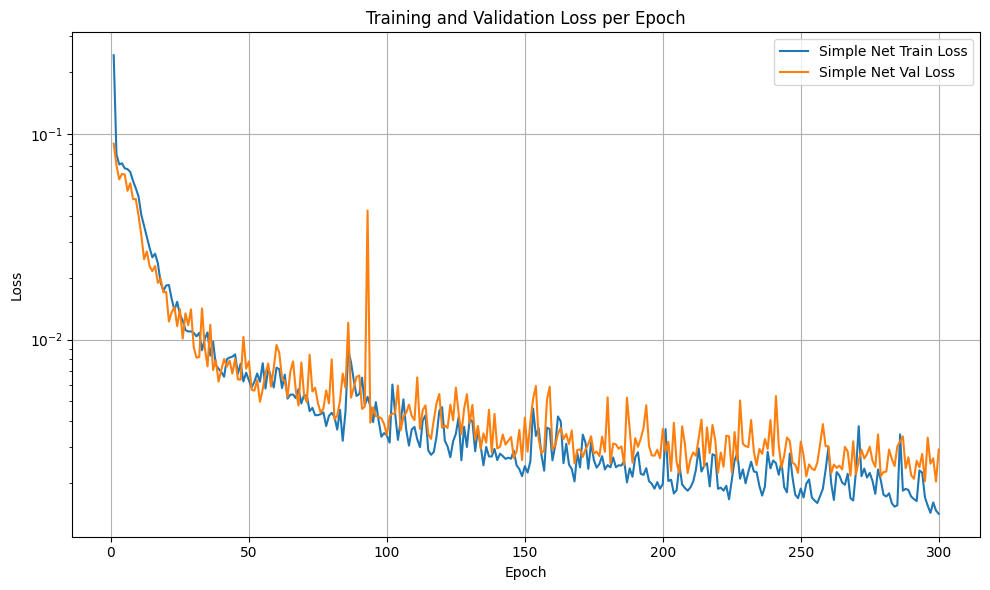

Final training loss: 0.00141858486174169
Final val loss: 0.002915684980025164
Best val loss (SmoothL1): 0.002034918776469487, epoch#: 298


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))

# SmoothL1 loss curves
plt.plot(epochs, train_losses, label='Simple Net Train Loss', linestyle='-')
plt.plot(epochs, val_losses, label='Simple Net Val Loss', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_losses[-1]}')
print(f'Final val loss: {val_losses[-1]}')

best_val_loss = min(val_losses)
best_epoch = val_losses.index(best_val_loss)
print(f'Best val loss (SmoothL1): {best_val_loss}, epoch#: {best_epoch}')


#### Loss function

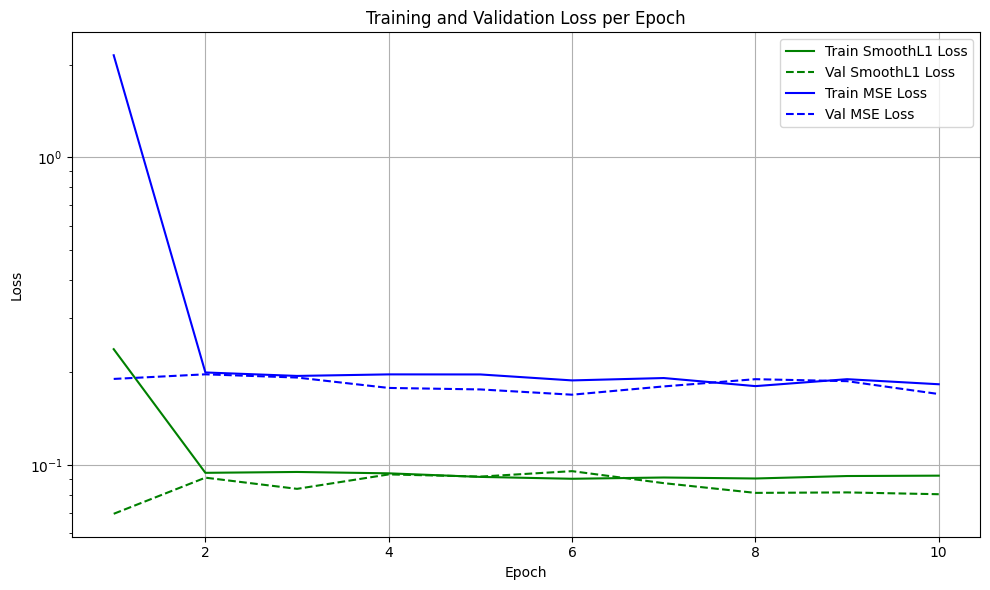

Final training loss: 0.09242875540443223, 0.18315610224338172
Final val loss: 0.08044344028357801, 0.17023054251865466
Best val loss (SmoothL1): 0.06948532591530011, epoch#: 0
Best val loss (MSE): 0.1693831400147506, epoch#: 5


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(SmoothL1_losses) + 1)

# plt.figure(figsize=(10, 6))

# # SmoothL1 loss curves
# plt.plot(epochs, SmoothL1_losses, label='Train SmoothL1 Loss', color='green', linestyle='-')
# plt.plot(epochs, val_SmoothL1_losses, label='Val SmoothL1 Loss', color='green', linestyle='--')

# # MSE loss curves
# plt.plot(epochs, MSE_losses, label='Train MSE Loss', color='blue', linestyle='-')
# plt.plot(epochs, val_MSE_losses, label='Val MSE Loss', color='blue', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {SmoothL1_losses[-1]}, {MSE_losses[-1]}')
# print(f'Final val loss: {val_SmoothL1_losses[-1]}, {val_MSE_losses[-1]}')

# best_val_loss = min(val_SmoothL1_losses)
# best_epoch = val_SmoothL1_losses.index(best_val_loss)
# print(f'Best val loss (SmoothL1): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(val_MSE_losses)
# best_epoch = val_MSE_losses.index(best_val_loss)
# print(f'Best val loss (MSE): {best_val_loss}, epoch#: {best_epoch}')


#### Batch Size

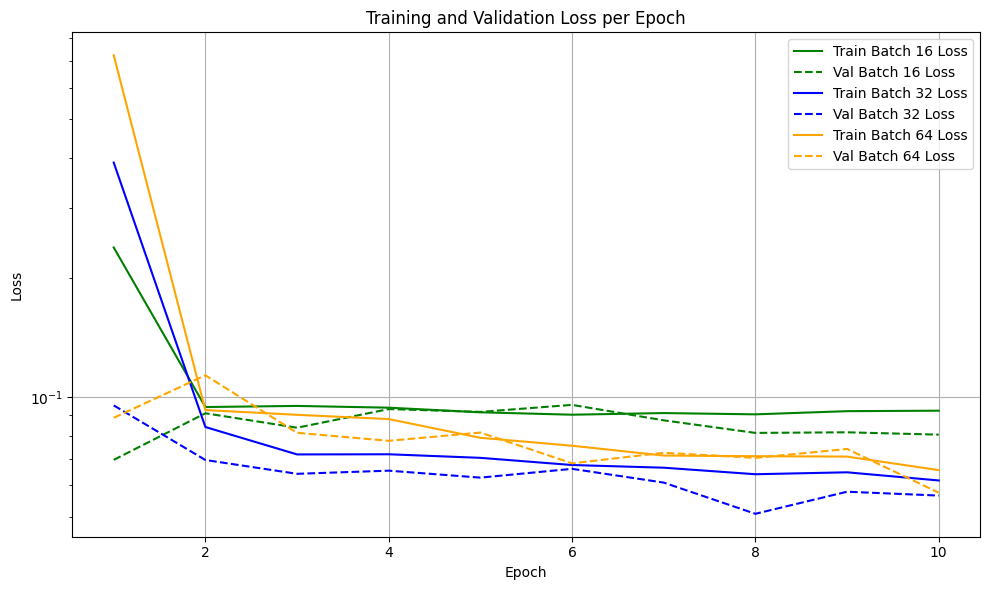

Final training loss: 0.09242875540443223, 0.06167978404789199, 0.06548963366943926
Final val loss: 0.08044344028357801, 0.056507733884966695, 0.05746516709373932
Best val loss (Batch 16): 0.06948532591530011, epoch#: 0
Best val loss (Batch 32): 0.05084166460482429, epoch#: 7
Best val loss (Batch 64): 0.05746516709373932, epoch#: 9


In [ ]:
# batch_16_L1_loss = SmoothL1_losses
# batch_16_L1_val_loss = val_SmoothL1_losses
# batch_16_L1_net = net_SmoothL1

# import matplotlib.pyplot as plt

# epochs = range(1, len(batch_16_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, batch_16_L1_loss, label='Train Batch 16 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_16_L1_val_loss, label='Val Batch 16 Loss', color='green', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train Batch 32 Loss', color='blue', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val Batch 32 Loss', color='blue', linestyle='--')

# # 64 loss curves
# plt.plot(epochs, batch_64_L1_loss, label='Train Batch 64 Loss', color='orange', linestyle='-')
# plt.plot(epochs, batch_64_L1_val_loss, label='Val Batch 64 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {batch_16_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {batch_64_L1_loss[-1]}')
# print(f'Final val loss: {batch_16_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {batch_64_L1_val_loss[-1]}')

# best_val_loss = min(batch_16_L1_val_loss)
# best_epoch = batch_16_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 16): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 32): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_64_L1_val_loss)
# best_epoch = batch_64_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 64): {best_val_loss}, epoch#: {best_epoch}')

#### Learning Rate

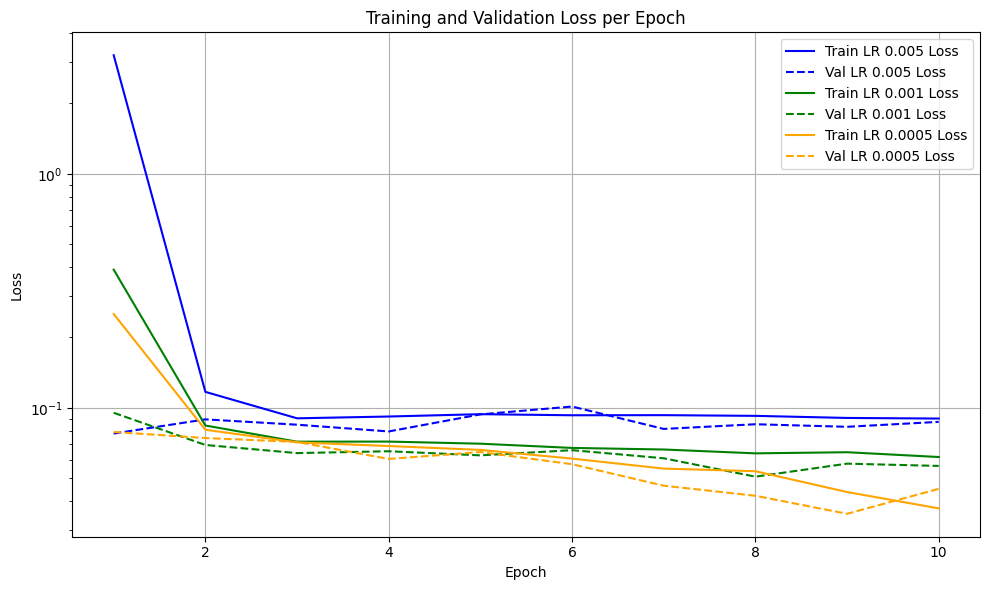

Final training loss: 0.037213279466794265, 0.06167978404789199, 0.09005379214909241
Final val loss: 0.04509976361784689, 0.056507733884966695, 0.08716710537090032
Best val loss (LR 0.005): 0.035286272131784334, epoch#: 8
Best val loss (LR 0.001): 0.05084166460482429, epoch#: 7
Best val loss (LR 0.0005): 0.07772143766586313, epoch#: 0


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, LR_00005_L1_loss, label='Train LR 0.005 Loss', color='blue', linestyle='-')
# plt.plot(epochs, LR_00005_L1_val_loss, label='Val LR 0.005 Loss', color='blue', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train LR 0.001 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val LR 0.001 Loss', color='green', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train LR 0.0005 Loss', color='orange', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val LR 0.0005 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {LR_00005_L1_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {LR_00005_L1_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.005): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.001): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(LR_00005_L1_val_loss)
# best_epoch = LR_00005_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.0005): {best_val_loss}, epoch#: {best_epoch}')

#### Optimizer

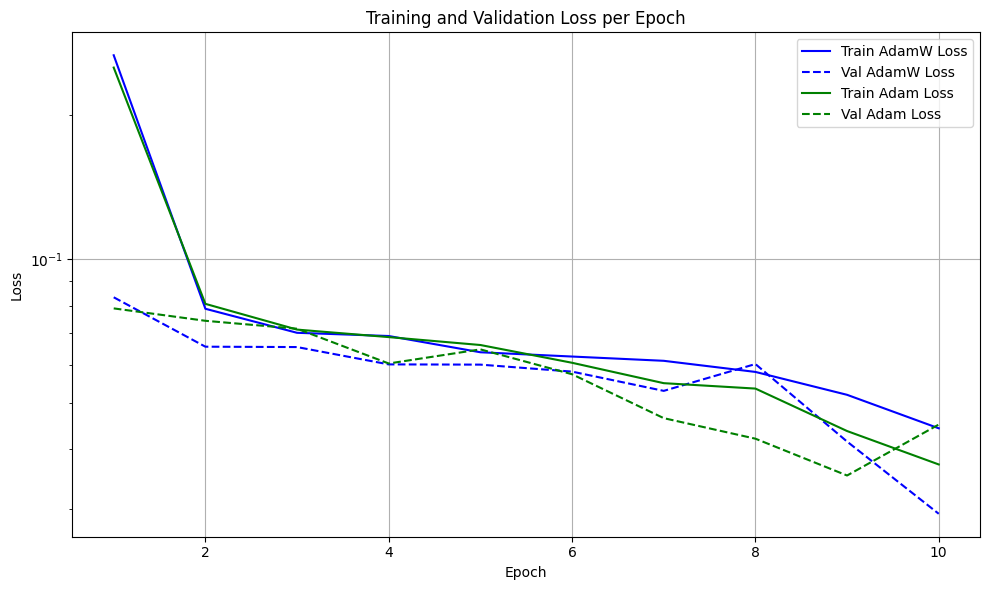

Final training loss: 0.037213279466794265, 0.04429485004647331
Final val loss: 0.04509976361784689, 0.02934233347240932
Best val loss (Adam): 0.035286272131784334, epoch#: 8
Best val loss (AdamW): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train AdamW Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val AdamW Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train Adam Loss', color='green', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val Adam Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Adam): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (AdamW): {best_val_loss}, epoch#: {best_epoch}')

#### Droupout

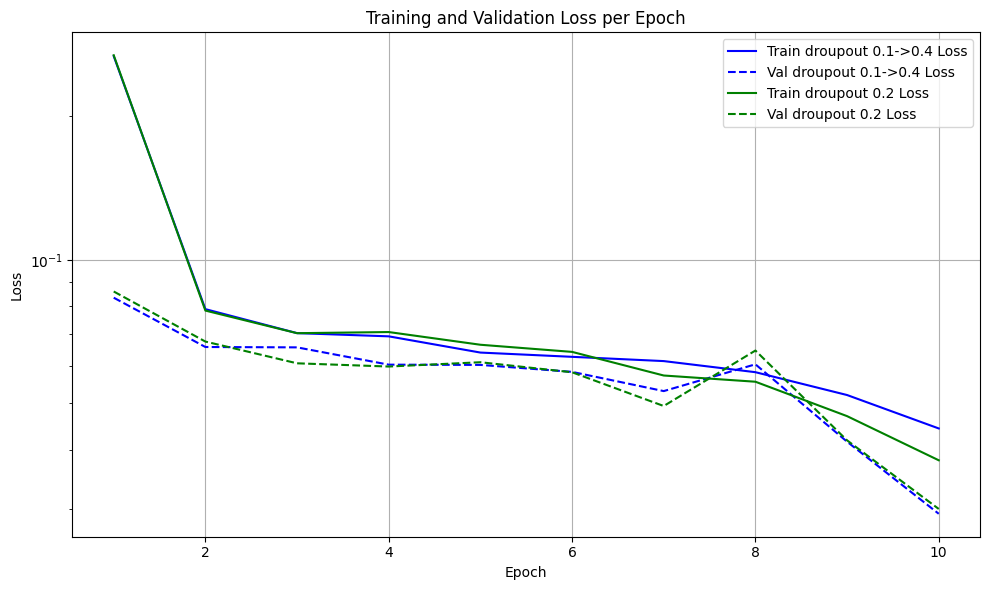

Final training loss: 0.03798806185916372, 0.04429485004647331
Final val loss: 0.030033955374372284, 0.02934233347240932
Best val loss (all 0.2): 0.030033955374372284, epoch#: 9
Best val loss (0.1->0.4): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(AdamW_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train droupout 0.1->0.4 Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val droupout 0.1->0.4 Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, droupout_all_02_loss, label='Train droupout 0.2 Loss', color='green', linestyle='-')
# plt.plot(epochs, droupout_all_02_val_loss, label='Val droupout 0.2 Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {droupout_all_02_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {droupout_all_02_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(droupout_all_02_val_loss)
# best_epoch = droupout_all_02_val_loss.index(best_val_loss)
# print(f'Best val loss (all 0.2): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (0.1->0.4): {best_val_loss}, epoch#: {best_epoch}')

### Evaluation-Metric

In [ ]:
from torch.nn import MSELoss
from torchsummary import summary

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")
# calcMSE(batch_16_L1_net)
# calcMSE(net_batch_32)
# calcMSE(net_LR_05)
# calcMSE(net_LR_00005)
# calcMSE(net_AdamW)
# calcMSE(net_batch_64)
# calcMSE(net_dropout_all_02)
net_pred_9 = SimpleNet()
net_pred_9.load_state_dict(torch.load("./models/simpleNet_epoch_9.pth"))
net_pred_19 = SimpleNet()
net_pred_19.load_state_dict(torch.load("./models/simpleNet_epoch_19.pth"))
net_pred_149 = SimpleNet()
net_pred_149.load_state_dict(torch.load("./models/simpleNet_epoch_149.pth"))
net_pred = SimpleNet()
net_pred.load_state_dict(torch.load("./models/simpleNet_best.pth"))
input_size = (1, 224, 224)
# summary(net_pred.cuda(), input_size)
calcMSE(net_pred_9)
calcMSE(net_pred_19)
calcMSE(net_pred_149)
calcMSE(net_pred)

Test Mean Squared Error: 0.0870
Test Mean Squared Error: 0.0278
Test Mean Squared Error: 0.0060
Test Mean Squared Error: 0.0038


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


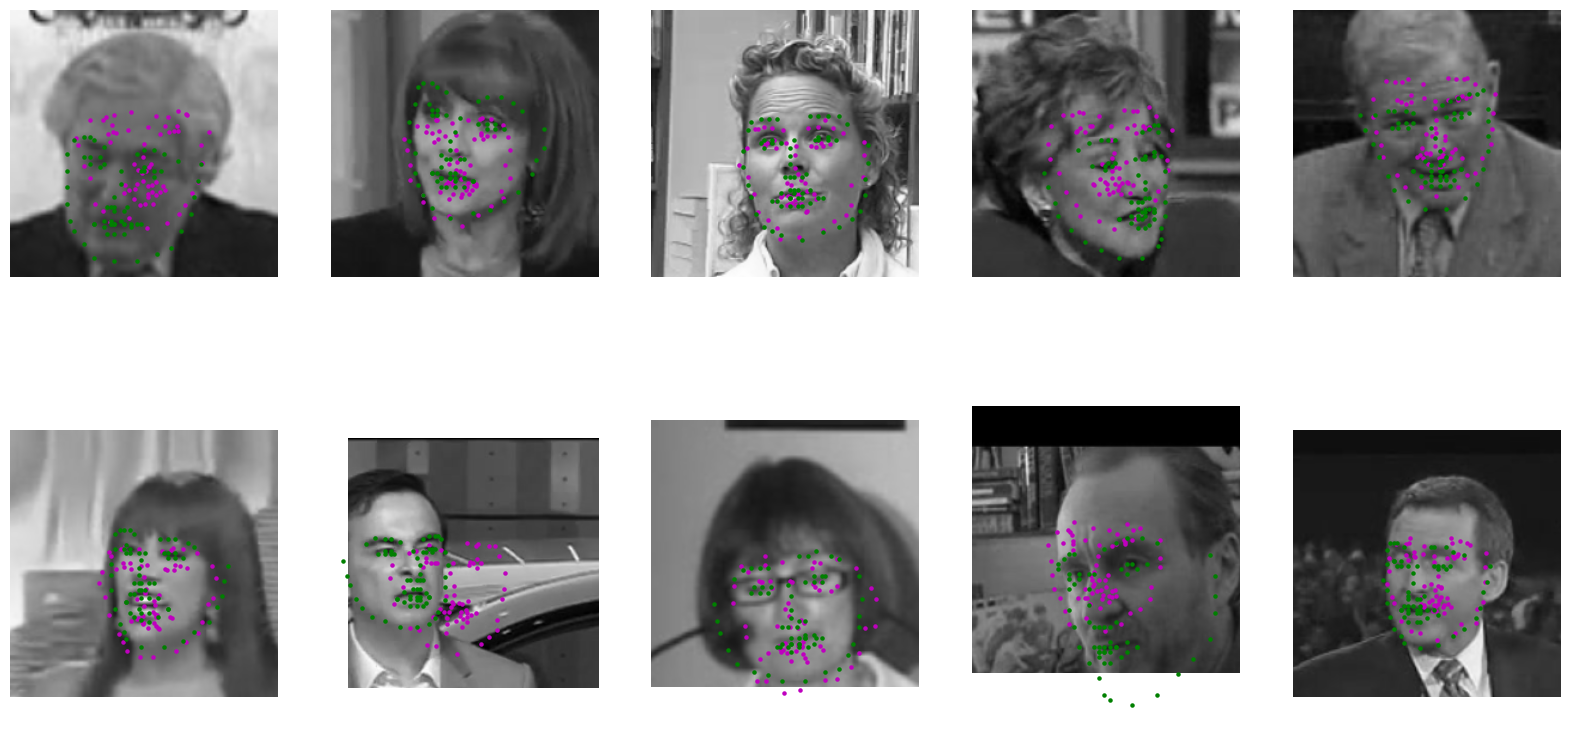

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


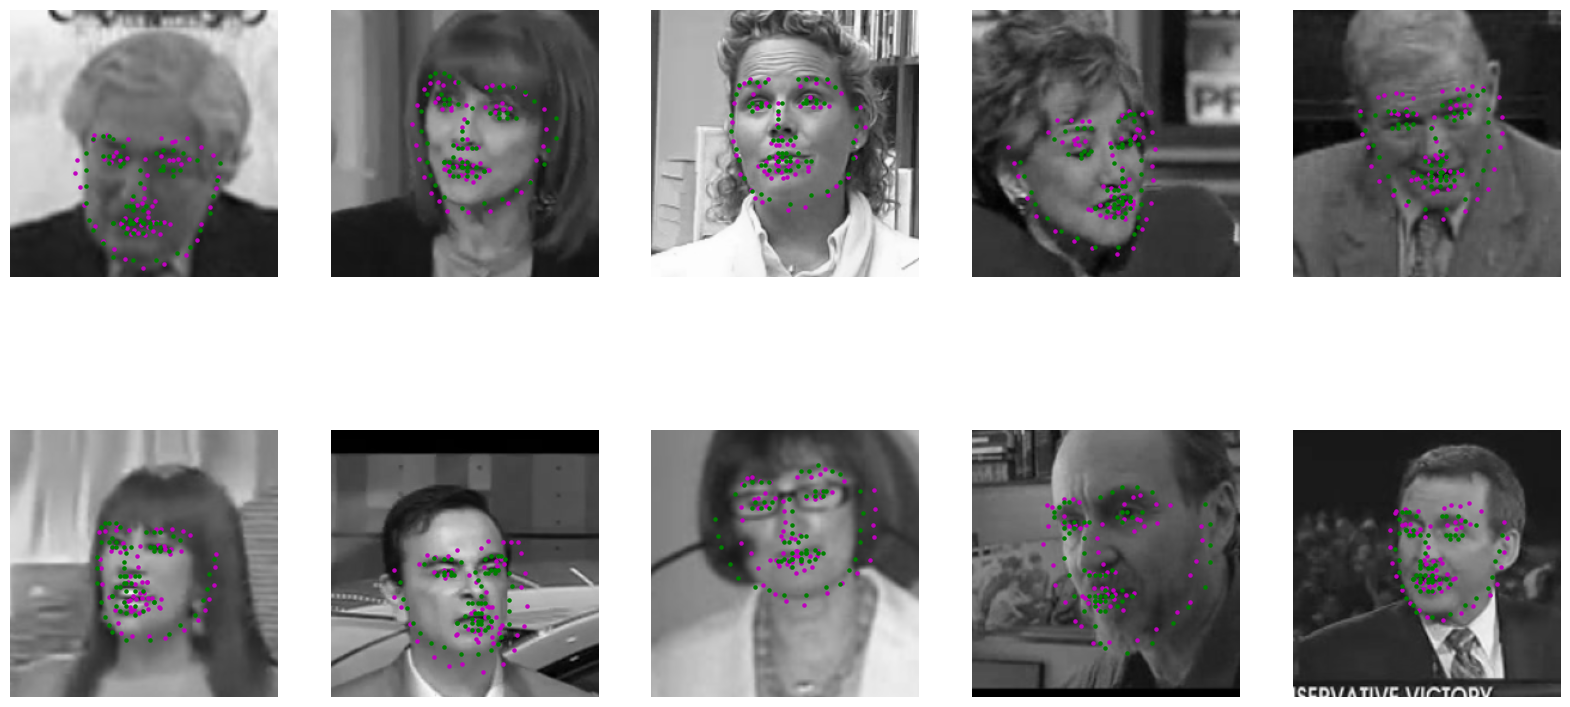

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


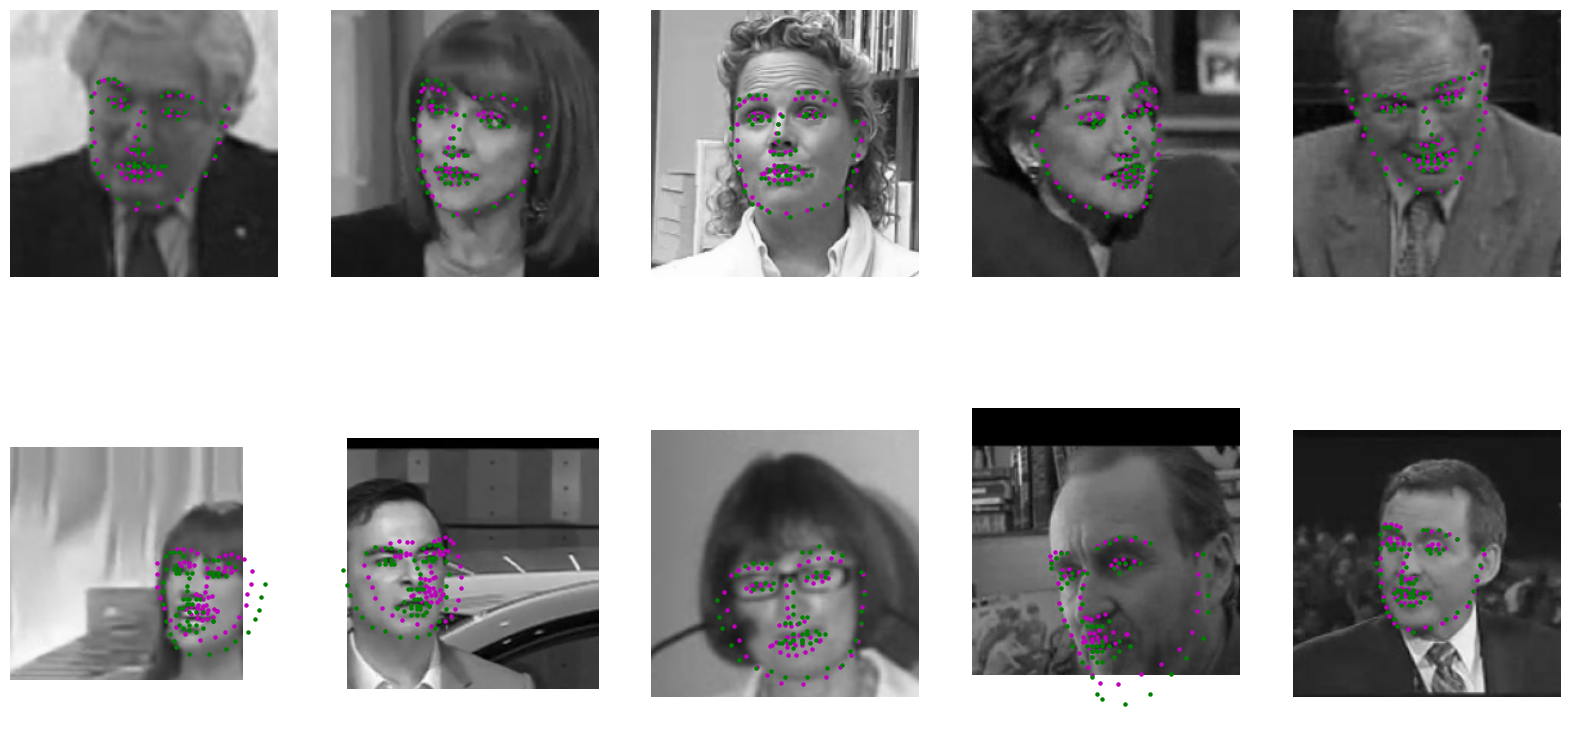

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


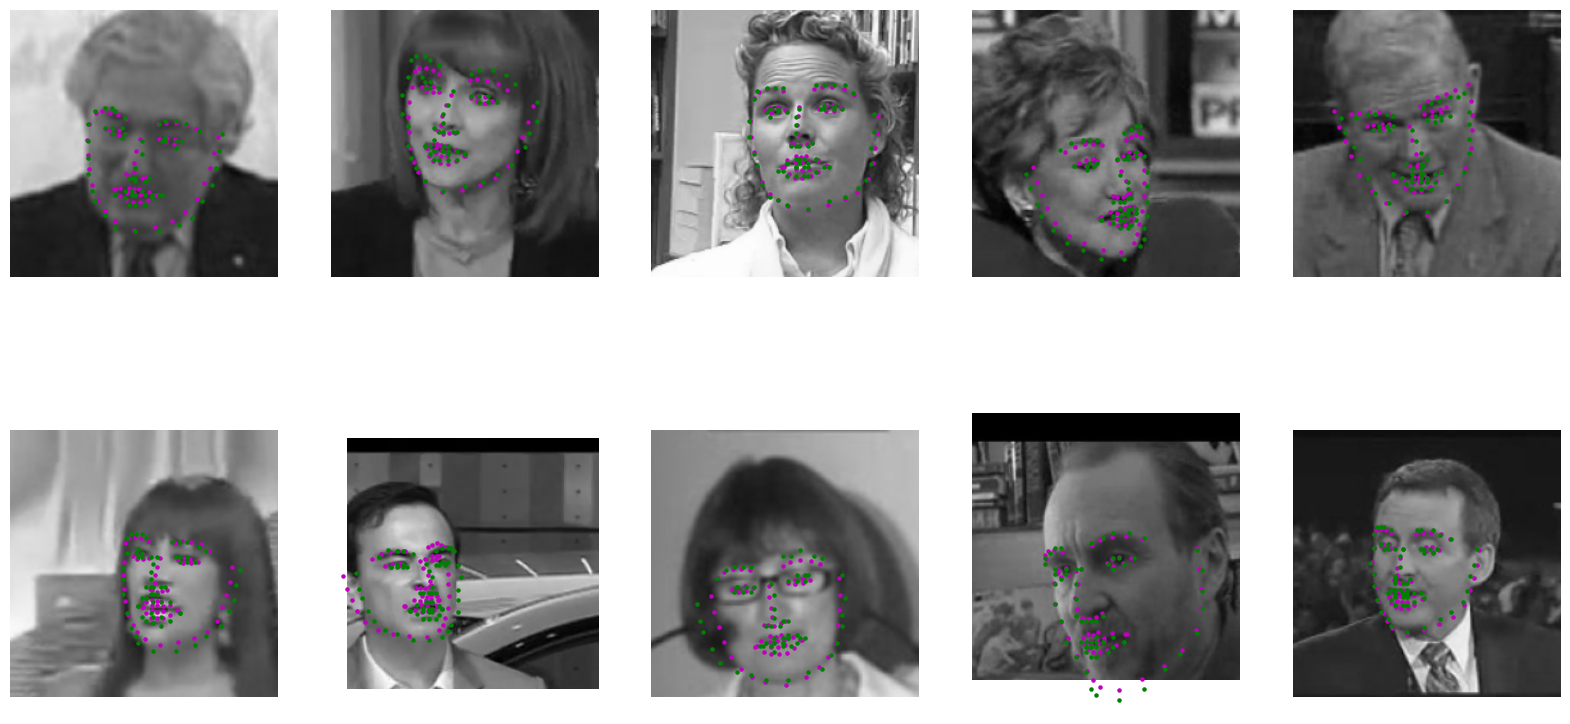

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()



def viz_wrap(net):
  test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

  print(test_images.data.size())
  print(test_outputs.data.size())
  print(gt_pts.size())

  # visualize the test output
  visualize_output(test_images, test_outputs, gt_pts)
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
viz_wrap(net_pred_9)
viz_wrap(net_pred_19)
viz_wrap(net_pred_149)
viz_wrap(net_pred)

## Part2-Transfer Learning

### General Train
* loss function: `SmoothL1Loss`
* Batch size: 32

In [ ]:
from models import Resnet18Grayscale, Resnet34Grayscale, DINOv2Keypoint, Resnet50Grayscale
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name, scheduler=None, clip_grad=None):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()
    best_val_loss = float("inf")

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()
            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()


            if clip_grad:
                torch.nn.utils.clip_grad_norm_(net.parameters(), clip_grad)


            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}_best.pth"
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        if scheduler:
            scheduler.step()

    return train_losses, val_losses

### ResNet

#### ResNet-Training
* ResNet18
* ResNet34
* Training Process: 5 for backbone + 10 for entire model

In [ ]:
def train_resnet(resnet, model_name):
  n_epochs_backbone_freeze = 10
  n_epochs_entire = 100
  # Freeze Backbone first
  for param in resnet.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
  loss, val_loss = train_net(resnet, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = resnet

  # Fine-tune
  for param in resnet.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.Adam(resnet.parameters(), lr=0.0005)
  fine_tune_loss, fine_tune_val_loss = train_net(resnet, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, resnet

def train_resnet50_with_warmup(net, model_name):
    # Stage 1: Freeze backbone
    for param in net.backbone.parameters():
        param.requires_grad = False
    optimizer_stage1 = AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, weight_decay=1e-4)
    scheduler_stage1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_stage1, T_max=10, eta_min=1e-6)
    loss_stage1, val_loss_stage1 = train_net(net, n_epochs=10,
                                             criterion=nn.SmoothL1Loss(),
                                             optimizer=optimizer_stage1,
                                             val_loader=test_loader,
                                             model_name=model_name + "_stage1",
                                             scheduler=scheduler_stage1,
                                             clip_grad=5.0)
    # Stage 2: Unfreeze backbone and fine-tune entire model with warm-up
    for param in net.backbone.parameters():
        param.requires_grad = True
    optimizer_stage2 = AdamW(net.parameters(), lr=0.0005, weight_decay=1e-4)

    n_epochs_stage2 = 90
    warmup_epochs = 5
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Warm-up: increase LR linearly from 0 to 1 multiplier
            return float(epoch + 1) / warmup_epochs
        else:
            # After warm-up, use cosine decay for the rest of the epochs
            cosine_epochs = n_epochs_stage2 - warmup_epochs
            progress = float(epoch - warmup_epochs) / cosine_epochs
            return 0.5 * (1.0 + math.cos(math.pi * progress))

    scheduler_stage2 = torch.optim.lr_scheduler.LambdaLR(optimizer_stage2, lr_lambda)
    loss_stage2, val_loss_stage2 = train_net(net, n_epochs=n_epochs_stage2,
                                             criterion=nn.SmoothL1Loss(),
                                             optimizer=optimizer_stage2,
                                             val_loader=test_loader,
                                             model_name=model_name + "_stage2",
                                             scheduler=scheduler_stage2,
                                             clip_grad=5.0)

    combined_train_loss = loss_stage1 + loss_stage2
    combined_val_loss = val_loss_stage1 + val_loss_stage2
    return combined_train_loss, combined_val_loss, net

# resnet34 = Resnet34Grayscale()
# train_loss, val_loss, resnet18 = train_resnet(resnet34, "resnet34_5_20")
resnet50 = Resnet50Grayscale()
train_loss, val_loss, resnet50 = train_resnet50_with_warmup(resnet50, "resnet50_10_90")

training:  10%|█         | 1/10 [00:06<00:59,  6.65s/it]

Saved best model (Val Loss: 0.0959)
Epoch 1/10 | Train Loss: 0.1359 | Val Loss: 0.0959



training:  20%|██        | 2/10 [00:13<00:52,  6.62s/it]

Saved best model (Val Loss: 0.0657)
Epoch 2/10 | Train Loss: 0.0851 | Val Loss: 0.0657



training:  30%|███       | 3/10 [00:19<00:46,  6.66s/it]

Saved best model (Val Loss: 0.0602)
Epoch 3/10 | Train Loss: 0.0685 | Val Loss: 0.0602



training:  40%|████      | 4/10 [00:26<00:39,  6.56s/it]

Epoch 4/10 | Train Loss: 0.0658 | Val Loss: 0.0603



training:  50%|█████     | 5/10 [00:33<00:33,  6.65s/it]

Saved best model (Val Loss: 0.0591)
Epoch 5/10 | Train Loss: 0.0592 | Val Loss: 0.0591



training:  60%|██████    | 6/10 [00:39<00:26,  6.64s/it]

Saved best model (Val Loss: 0.0515)
Epoch 6/10 | Train Loss: 0.0595 | Val Loss: 0.0515



training:  70%|███████   | 7/10 [00:46<00:19,  6.57s/it]

Epoch 7/10 | Train Loss: 0.0561 | Val Loss: 0.0555



training:  80%|████████  | 8/10 [00:52<00:13,  6.53s/it]

Epoch 8/10 | Train Loss: 0.0569 | Val Loss: 0.0545



training:  90%|█████████ | 9/10 [00:59<00:06,  6.50s/it]

Epoch 9/10 | Train Loss: 0.0519 | Val Loss: 0.0547



training: 100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


Epoch 10/10 | Train Loss: 0.0518 | Val Loss: 0.0542


training:   1%|          | 1/100 [00:07<11:36,  7.03s/it]

Saved best model (Val Loss: 0.0644)
Epoch 1/100 | Train Loss: 0.0764 | Val Loss: 0.0644



training:   2%|▏         | 2/100 [00:13<11:24,  6.99s/it]

Saved best model (Val Loss: 0.0523)
Epoch 2/100 | Train Loss: 0.0619 | Val Loss: 0.0523



training:   3%|▎         | 3/100 [00:20<11:02,  6.83s/it]

Epoch 3/100 | Train Loss: 0.0602 | Val Loss: 0.0555



training:   4%|▍         | 4/100 [00:27<10:58,  6.86s/it]

Saved best model (Val Loss: 0.0521)
Epoch 4/100 | Train Loss: 0.0540 | Val Loss: 0.0521



training:   5%|▌         | 5/100 [00:34<10:54,  6.89s/it]

Saved best model (Val Loss: 0.0484)
Epoch 5/100 | Train Loss: 0.0542 | Val Loss: 0.0484



training:   6%|▌         | 6/100 [00:41<10:48,  6.90s/it]

Saved best model (Val Loss: 0.0482)
Epoch 6/100 | Train Loss: 0.0543 | Val Loss: 0.0482



training:   7%|▋         | 7/100 [00:48<10:39,  6.87s/it]

Epoch 7/100 | Train Loss: 0.0540 | Val Loss: 0.0486



training:   8%|▊         | 8/100 [00:55<10:32,  6.88s/it]

Saved best model (Val Loss: 0.0427)
Epoch 8/100 | Train Loss: 0.0532 | Val Loss: 0.0427



training:   9%|▉         | 9/100 [01:01<10:22,  6.84s/it]

Epoch 9/100 | Train Loss: 0.0505 | Val Loss: 0.0539



training:  10%|█         | 10/100 [01:08<10:13,  6.81s/it]

Epoch 10/100 | Train Loss: 0.0490 | Val Loss: 0.0458



training:  11%|█         | 11/100 [01:15<10:07,  6.82s/it]

Saved best model (Val Loss: 0.0417)
Epoch 11/100 | Train Loss: 0.0469 | Val Loss: 0.0417



training:  12%|█▏        | 12/100 [01:22<09:57,  6.79s/it]

Epoch 12/100 | Train Loss: 0.0492 | Val Loss: 0.0669



training:  13%|█▎        | 13/100 [01:28<09:49,  6.77s/it]

Epoch 13/100 | Train Loss: 0.0524 | Val Loss: 0.0499



training:  14%|█▍        | 14/100 [01:35<09:43,  6.78s/it]

Epoch 14/100 | Train Loss: 0.0493 | Val Loss: 0.0430



training:  15%|█▌        | 15/100 [01:42<09:34,  6.76s/it]

Epoch 15/100 | Train Loss: 0.0477 | Val Loss: 0.0473



training:  16%|█▌        | 16/100 [01:49<09:25,  6.74s/it]

Epoch 16/100 | Train Loss: 0.0492 | Val Loss: 0.0479



training:  17%|█▋        | 17/100 [01:56<09:23,  6.78s/it]

Saved best model (Val Loss: 0.0417)
Epoch 17/100 | Train Loss: 0.0490 | Val Loss: 0.0417



training:  18%|█▊        | 18/100 [02:02<09:11,  6.73s/it]

Epoch 18/100 | Train Loss: 0.0452 | Val Loss: 0.0432



training:  19%|█▉        | 19/100 [02:09<09:06,  6.74s/it]

Epoch 19/100 | Train Loss: 0.0469 | Val Loss: 0.0446



training:  20%|██        | 20/100 [02:16<09:04,  6.81s/it]

Saved best model (Val Loss: 0.0415)
Epoch 20/100 | Train Loss: 0.0487 | Val Loss: 0.0415



training:  21%|██        | 21/100 [02:23<08:57,  6.80s/it]

Epoch 21/100 | Train Loss: 0.0471 | Val Loss: 0.0434



training:  22%|██▏       | 22/100 [02:30<08:52,  6.82s/it]

Saved best model (Val Loss: 0.0413)
Epoch 22/100 | Train Loss: 0.0477 | Val Loss: 0.0413



training:  23%|██▎       | 23/100 [02:36<08:42,  6.79s/it]

Epoch 23/100 | Train Loss: 0.0474 | Val Loss: 0.0425



training:  24%|██▍       | 24/100 [02:43<08:35,  6.79s/it]

Epoch 24/100 | Train Loss: 0.0458 | Val Loss: 0.0437



training:  25%|██▌       | 25/100 [02:50<08:24,  6.73s/it]

Epoch 25/100 | Train Loss: 0.0432 | Val Loss: 0.0442



training:  26%|██▌       | 26/100 [02:57<08:25,  6.83s/it]

Saved best model (Val Loss: 0.0401)
Epoch 26/100 | Train Loss: 0.0458 | Val Loss: 0.0401



training:  27%|██▋       | 27/100 [03:03<08:15,  6.79s/it]

Epoch 27/100 | Train Loss: 0.0455 | Val Loss: 0.0405



training:  28%|██▊       | 28/100 [03:10<08:06,  6.76s/it]

Epoch 28/100 | Train Loss: 0.0475 | Val Loss: 0.0653



training:  29%|██▉       | 29/100 [03:17<07:58,  6.74s/it]

Epoch 29/100 | Train Loss: 0.0435 | Val Loss: 0.0431



training:  30%|███       | 30/100 [03:23<07:49,  6.71s/it]

Epoch 30/100 | Train Loss: 0.0432 | Val Loss: 0.0418



training:  31%|███       | 31/100 [03:30<07:42,  6.70s/it]

Epoch 31/100 | Train Loss: 0.0444 | Val Loss: 0.0418



training:  32%|███▏      | 32/100 [03:37<07:40,  6.78s/it]

Saved best model (Val Loss: 0.0364)
Epoch 32/100 | Train Loss: 0.0426 | Val Loss: 0.0364



training:  33%|███▎      | 33/100 [03:44<07:32,  6.75s/it]

Epoch 33/100 | Train Loss: 0.0445 | Val Loss: 0.0400



training:  34%|███▍      | 34/100 [03:50<07:22,  6.70s/it]

Epoch 34/100 | Train Loss: 0.0421 | Val Loss: 0.0402



training:  35%|███▌      | 35/100 [03:57<07:15,  6.70s/it]

Epoch 35/100 | Train Loss: 0.0431 | Val Loss: 0.0415



training:  36%|███▌      | 36/100 [04:04<07:08,  6.70s/it]

Epoch 36/100 | Train Loss: 0.0452 | Val Loss: 0.0393



training:  37%|███▋      | 37/100 [04:10<07:02,  6.70s/it]

Epoch 37/100 | Train Loss: 0.0423 | Val Loss: 0.0415



training:  38%|███▊      | 38/100 [04:17<06:57,  6.73s/it]

Epoch 38/100 | Train Loss: 0.0426 | Val Loss: 0.0431



training:  39%|███▉      | 39/100 [04:24<06:50,  6.72s/it]

Epoch 39/100 | Train Loss: 0.0446 | Val Loss: 0.0385



training:  40%|████      | 40/100 [04:31<06:41,  6.69s/it]

Epoch 40/100 | Train Loss: 0.0434 | Val Loss: 0.0386



training:  41%|████      | 41/100 [04:37<06:34,  6.69s/it]

Epoch 41/100 | Train Loss: 0.0420 | Val Loss: 0.0428



training:  42%|████▏     | 42/100 [04:44<06:27,  6.68s/it]

Epoch 42/100 | Train Loss: 0.0431 | Val Loss: 0.0410



training:  43%|████▎     | 43/100 [04:51<06:27,  6.79s/it]

Saved best model (Val Loss: 0.0358)
Epoch 43/100 | Train Loss: 0.0403 | Val Loss: 0.0358



training:  44%|████▍     | 44/100 [04:58<06:18,  6.76s/it]

Epoch 44/100 | Train Loss: 0.0421 | Val Loss: 0.0378



training:  45%|████▌     | 45/100 [05:04<06:13,  6.79s/it]

Epoch 45/100 | Train Loss: 0.0457 | Val Loss: 0.0560



training:  46%|████▌     | 46/100 [05:11<06:06,  6.79s/it]

Epoch 46/100 | Train Loss: 0.0409 | Val Loss: 0.0410



training:  47%|████▋     | 47/100 [05:18<05:58,  6.76s/it]

Epoch 47/100 | Train Loss: 0.0422 | Val Loss: 0.0419



training:  48%|████▊     | 48/100 [05:25<05:52,  6.77s/it]

Epoch 48/100 | Train Loss: 0.0427 | Val Loss: 0.0359



training:  49%|████▉     | 49/100 [05:31<05:43,  6.74s/it]

Epoch 49/100 | Train Loss: 0.0403 | Val Loss: 0.0376



training:  50%|█████     | 50/100 [05:38<05:40,  6.81s/it]

Saved best model (Val Loss: 0.0357)
Epoch 50/100 | Train Loss: 0.0392 | Val Loss: 0.0357



training:  51%|█████     | 51/100 [05:45<05:32,  6.79s/it]

Epoch 51/100 | Train Loss: 0.0406 | Val Loss: 0.0377



training:  52%|█████▏    | 52/100 [05:52<05:24,  6.76s/it]

Epoch 52/100 | Train Loss: 0.0385 | Val Loss: 0.0390



training:  53%|█████▎    | 53/100 [05:59<05:17,  6.75s/it]

Epoch 53/100 | Train Loss: 0.0400 | Val Loss: 0.0443



training:  54%|█████▍    | 54/100 [06:05<05:09,  6.72s/it]

Epoch 54/100 | Train Loss: 0.0404 | Val Loss: 0.0377



training:  55%|█████▌    | 55/100 [06:12<05:04,  6.76s/it]

Epoch 55/100 | Train Loss: 0.0415 | Val Loss: 0.0379



training:  56%|█████▌    | 56/100 [06:19<04:55,  6.72s/it]

Epoch 56/100 | Train Loss: 0.0417 | Val Loss: 0.0402



training:  57%|█████▋    | 57/100 [06:25<04:49,  6.73s/it]

Epoch 57/100 | Train Loss: 0.0410 | Val Loss: 0.0392



training:  58%|█████▊    | 58/100 [06:32<04:45,  6.80s/it]

Saved best model (Val Loss: 0.0356)
Epoch 58/100 | Train Loss: 0.0396 | Val Loss: 0.0356



training:  59%|█████▉    | 59/100 [06:39<04:37,  6.76s/it]

Epoch 59/100 | Train Loss: 0.0399 | Val Loss: 0.0374



training:  60%|██████    | 60/100 [06:46<04:30,  6.76s/it]

Epoch 60/100 | Train Loss: 0.0397 | Val Loss: 0.0432



training:  61%|██████    | 61/100 [06:52<04:21,  6.71s/it]

Epoch 61/100 | Train Loss: 0.0395 | Val Loss: 0.0377



training:  62%|██████▏   | 62/100 [06:59<04:15,  6.72s/it]

Epoch 62/100 | Train Loss: 0.0415 | Val Loss: 0.0431



training:  63%|██████▎   | 63/100 [07:06<04:09,  6.74s/it]

Epoch 63/100 | Train Loss: 0.0394 | Val Loss: 0.0376



training:  64%|██████▍   | 64/100 [07:13<04:01,  6.72s/it]

Epoch 64/100 | Train Loss: 0.0394 | Val Loss: 0.0366



training:  65%|██████▌   | 65/100 [07:20<03:57,  6.78s/it]

Saved best model (Val Loss: 0.0352)
Epoch 65/100 | Train Loss: 0.0385 | Val Loss: 0.0352



training:  66%|██████▌   | 66/100 [07:26<03:49,  6.74s/it]

Epoch 66/100 | Train Loss: 0.0420 | Val Loss: 0.0434



training:  67%|██████▋   | 67/100 [07:33<03:43,  6.76s/it]

Epoch 67/100 | Train Loss: 0.0379 | Val Loss: 0.0355



training:  68%|██████▊   | 68/100 [07:40<03:36,  6.75s/it]

Epoch 68/100 | Train Loss: 0.0390 | Val Loss: 0.0441



training:  69%|██████▉   | 69/100 [07:46<03:29,  6.75s/it]

Epoch 69/100 | Train Loss: 0.0401 | Val Loss: 0.0403



training:  70%|███████   | 70/100 [07:53<03:22,  6.75s/it]

Epoch 70/100 | Train Loss: 0.0408 | Val Loss: 0.0387



training:  71%|███████   | 71/100 [08:00<03:15,  6.73s/it]

Epoch 71/100 | Train Loss: 0.0394 | Val Loss: 0.0376



training:  72%|███████▏  | 72/100 [08:07<03:08,  6.73s/it]

Epoch 72/100 | Train Loss: 0.0383 | Val Loss: 0.0389



training:  73%|███████▎  | 73/100 [08:14<03:03,  6.79s/it]

Saved best model (Val Loss: 0.0347)
Epoch 73/100 | Train Loss: 0.0394 | Val Loss: 0.0347



training:  74%|███████▍  | 74/100 [08:20<02:56,  6.79s/it]

Epoch 74/100 | Train Loss: 0.0399 | Val Loss: 0.0472



training:  75%|███████▌  | 75/100 [08:27<02:48,  6.75s/it]

Epoch 75/100 | Train Loss: 0.0382 | Val Loss: 0.0444



training:  76%|███████▌  | 76/100 [08:34<02:41,  6.74s/it]

Epoch 76/100 | Train Loss: 0.0389 | Val Loss: 0.0423



training:  77%|███████▋  | 77/100 [08:40<02:35,  6.74s/it]

Epoch 77/100 | Train Loss: 0.0392 | Val Loss: 0.0467



training:  78%|███████▊  | 78/100 [08:47<02:28,  6.73s/it]

Epoch 78/100 | Train Loss: 0.0397 | Val Loss: 0.0383



training:  79%|███████▉  | 79/100 [08:54<02:21,  6.75s/it]

Epoch 79/100 | Train Loss: 0.0391 | Val Loss: 0.0388



training:  80%|████████  | 80/100 [09:01<02:15,  6.77s/it]

Epoch 80/100 | Train Loss: 0.0398 | Val Loss: 0.0381



training:  81%|████████  | 81/100 [09:08<02:08,  6.78s/it]

Epoch 81/100 | Train Loss: 0.0382 | Val Loss: 0.0408



training:  82%|████████▏ | 82/100 [09:14<02:02,  6.78s/it]

Epoch 82/100 | Train Loss: 0.0378 | Val Loss: 0.0382



training:  83%|████████▎ | 83/100 [09:21<01:56,  6.85s/it]

Saved best model (Val Loss: 0.0327)
Epoch 83/100 | Train Loss: 0.0365 | Val Loss: 0.0327



training:  84%|████████▍ | 84/100 [09:28<01:49,  6.87s/it]

Epoch 84/100 | Train Loss: 0.0390 | Val Loss: 0.0411



training:  85%|████████▌ | 85/100 [09:35<01:42,  6.83s/it]

Epoch 85/100 | Train Loss: 0.0366 | Val Loss: 0.0407



training:  86%|████████▌ | 86/100 [09:42<01:35,  6.85s/it]

Epoch 86/100 | Train Loss: 0.0387 | Val Loss: 0.0381



training:  87%|████████▋ | 87/100 [09:49<01:28,  6.82s/it]

Epoch 87/100 | Train Loss: 0.0391 | Val Loss: 0.0367



training:  88%|████████▊ | 88/100 [09:56<01:22,  6.91s/it]

Saved best model (Val Loss: 0.0311)
Epoch 88/100 | Train Loss: 0.0371 | Val Loss: 0.0311



training:  89%|████████▉ | 89/100 [10:03<01:15,  6.89s/it]

Epoch 89/100 | Train Loss: 0.0364 | Val Loss: 0.0359



training:  90%|█████████ | 90/100 [10:10<01:08,  6.89s/it]

Epoch 90/100 | Train Loss: 0.0405 | Val Loss: 0.0399



training:  91%|█████████ | 91/100 [10:16<01:02,  6.89s/it]

Epoch 91/100 | Train Loss: 0.0408 | Val Loss: 0.0352



training:  92%|█████████▏| 92/100 [10:23<00:55,  6.88s/it]

Epoch 92/100 | Train Loss: 0.0358 | Val Loss: 0.0411



training:  93%|█████████▎| 93/100 [10:30<00:48,  6.87s/it]

Epoch 93/100 | Train Loss: 0.0365 | Val Loss: 0.0347



training:  94%|█████████▍| 94/100 [10:37<00:41,  6.86s/it]

Epoch 94/100 | Train Loss: 0.0369 | Val Loss: 0.0498



training:  95%|█████████▌| 95/100 [10:44<00:34,  6.86s/it]

Epoch 95/100 | Train Loss: 0.0389 | Val Loss: 0.0360



training:  96%|█████████▌| 96/100 [10:51<00:27,  6.88s/it]

Epoch 96/100 | Train Loss: 0.0379 | Val Loss: 0.0356



training:  97%|█████████▋| 97/100 [10:58<00:20,  6.89s/it]

Epoch 97/100 | Train Loss: 0.0375 | Val Loss: 0.0344



training:  98%|█████████▊| 98/100 [11:05<00:13,  6.90s/it]

Epoch 98/100 | Train Loss: 0.0369 | Val Loss: 0.0356



training:  99%|█████████▉| 99/100 [11:11<00:06,  6.91s/it]

Epoch 99/100 | Train Loss: 0.0374 | Val Loss: 0.0361



training: 100%|██████████| 100/100 [11:18<00:00,  6.79s/it]

Epoch 100/100 | Train Loss: 0.0356 | Val Loss: 0.0383


#### ResNet-Evaluation-Viz

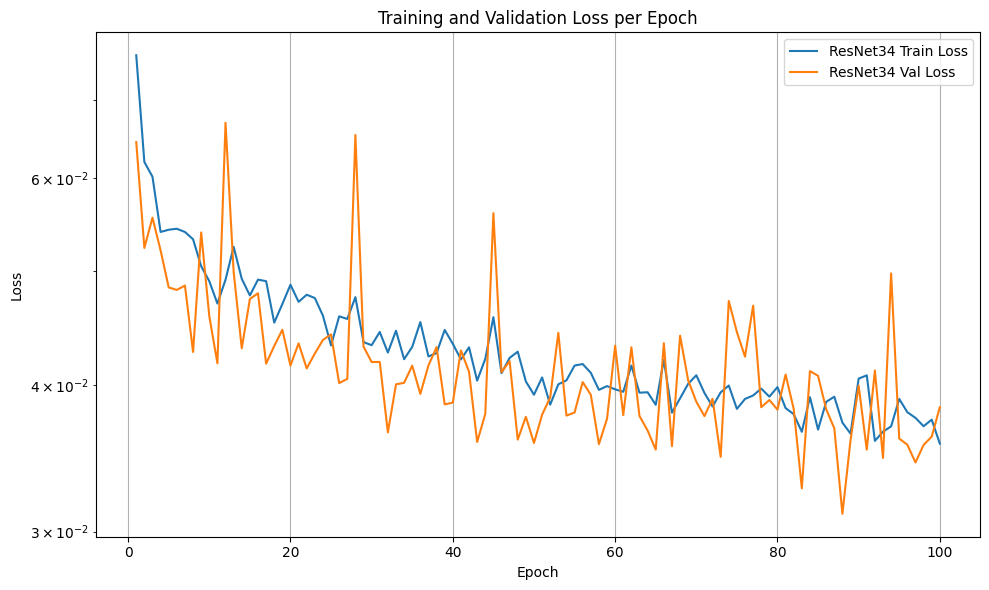

Final training loss: 0.035645382630224084
Final val loss: 0.03828128023956873
Best val loss: 0.031061840067772708, epoch#: 87


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))


# plt.plot(epochs, resnet18_loss, label='ResNet18 Frozen Backbone Train Loss', color='blue', linestyle='-')
# plt.plot(epochs, resnet18_val_loss, label='ResNet18 Frozen Backbone Val Loss', color='blue', linestyle='--')


plt.plot(epochs, train_loss, label='ResNet34 Train Loss', linestyle='-')
plt.plot(epochs, val_loss, label='ResNet34 Val Loss', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_loss[-1]}')
print(f'Final val loss: {val_loss[-1]}')

best_val_loss = min(val_loss)
best_epoch = val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

#### ResNet-Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")

net_pred = Resnet34Grayscale()
net_pred.load_state_dict(torch.load("./models/resnet34_5_20_best.pth"))
# calcMSE(resnet18)
calcMSE(resnet34)

Test Mean Squared Error: 0.0787


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


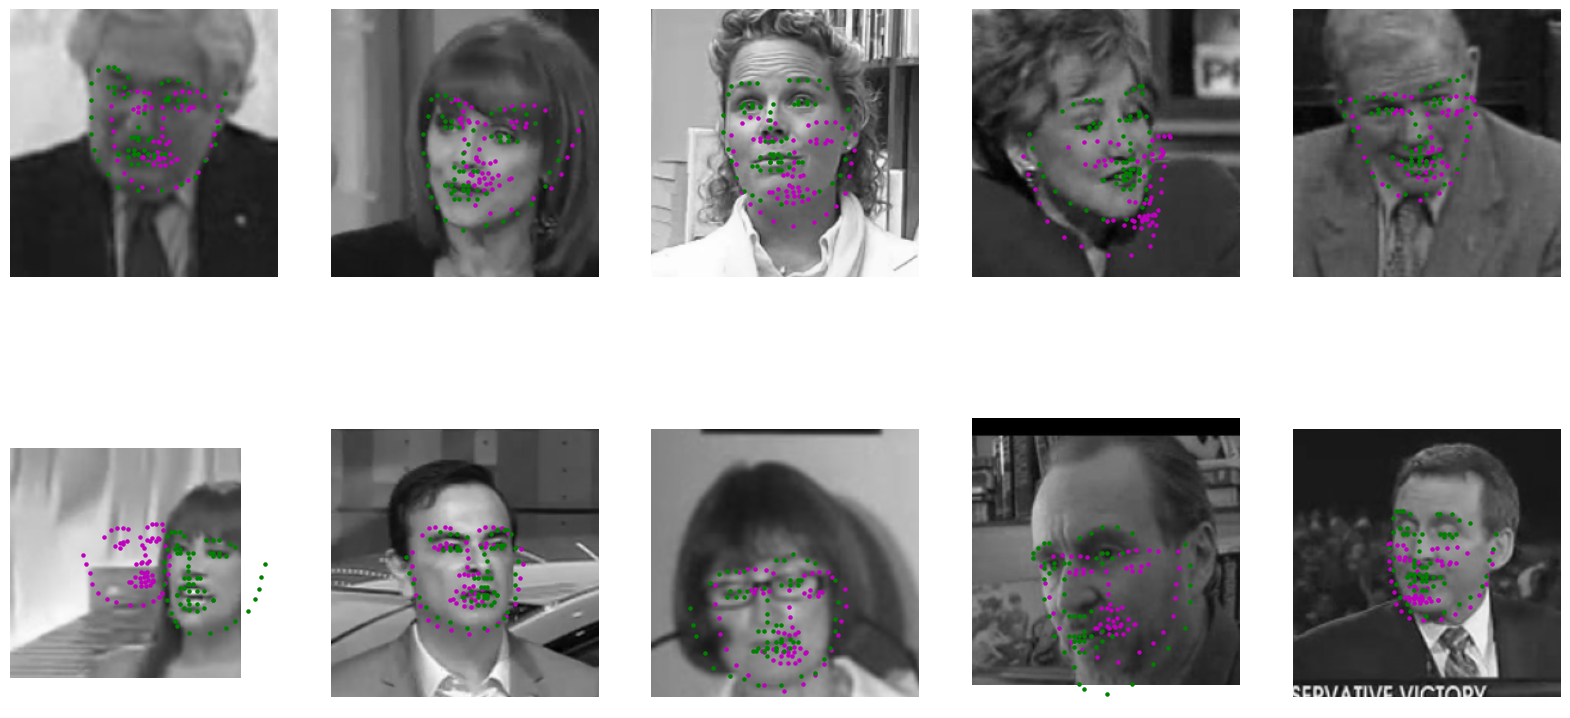

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()



def viz_wrap(net):
  test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

  print(test_images.data.size())
  print(test_outputs.data.size())
  print(gt_pts.size())

  # visualize the test output
  visualize_output(test_images, test_outputs, gt_pts)
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
viz_wrap(net_pred)

### DINO

#### DINO-Training

In [ ]:
def train_dino(dino, model_name):
  n_epochs_backbone_freeze = 10
  n_epochs_entire = 50
  # Freeze Backbone first
  for param in dino.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.AdamW(filter(lambda p: p.requires_grad, dino.parameters()), lr=1e-3)
  loss, val_loss = train_net(dino, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = dino

  # Fine-tune
  for param in dino.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.AdamW(dino.parameters(), lr=1e-4)
  fine_tune_loss, fine_tune_val_loss = train_net(dino, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, dino


dino = DINOv2Keypoint()

train_loss, val_loss, dino = train_dino(dino, "dino")

epoch 0:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

training:  20%|██        | 1/5 [01:09<04:37, 69.29s/it]

Saved best model (Val Loss: 0.1015)
Epoch 1/5 | Train Loss: 0.1042 | Val Loss: 0.1015



training:  40%|████      | 2/5 [02:15<03:22, 67.52s/it]

Saved best model (Val Loss: 0.0844)
Epoch 2/5 | Train Loss: 0.0989 | Val Loss: 0.0844



training:  60%|██████    | 3/5 [03:21<02:13, 66.73s/it]

Saved best model (Val Loss: 0.0905)
Epoch 3/5 | Train Loss: 0.0928 | Val Loss: 0.0905



training:  80%|████████  | 4/5 [04:27<01:06, 66.38s/it]

Saved best model (Val Loss: 0.0858)
Epoch 4/5 | Train Loss: 0.0936 | Val Loss: 0.0858



training: 100%|██████████| 5/5 [05:33<00:00, 66.66s/it]


Saved best model (Val Loss: 0.0924)
Epoch 5/5 | Train Loss: 0.0967 | Val Loss: 0.0924


training:  10%|█         | 1/10 [02:44<24:42, 164.69s/it]

Saved best model (Val Loss: 0.0881)
Epoch 1/10 | Train Loss: 0.0958 | Val Loss: 0.0881



training:  20%|██        | 2/10 [05:30<22:01, 165.19s/it]

Saved best model (Val Loss: 0.0840)
Epoch 2/10 | Train Loss: 0.0972 | Val Loss: 0.0840



training:  30%|███       | 3/10 [08:15<19:15, 165.03s/it]

Saved best model (Val Loss: 0.0883)
Epoch 3/10 | Train Loss: 0.0965 | Val Loss: 0.0883



training:  40%|████      | 4/10 [11:00<16:30, 165.14s/it]

Saved best model (Val Loss: 0.0844)
Epoch 4/10 | Train Loss: 0.0939 | Val Loss: 0.0844



training:  50%|█████     | 5/10 [13:45<13:44, 164.98s/it]

Saved best model (Val Loss: 0.0857)
Epoch 5/10 | Train Loss: 0.0912 | Val Loss: 0.0857



training:  60%|██████    | 6/10 [16:30<11:00, 165.12s/it]

Saved best model (Val Loss: 0.0862)
Epoch 6/10 | Train Loss: 0.0920 | Val Loss: 0.0862



training:  70%|███████   | 7/10 [19:15<08:15, 165.10s/it]

Saved best model (Val Loss: 0.0824)
Epoch 7/10 | Train Loss: 0.0901 | Val Loss: 0.0824



training:  80%|████████  | 8/10 [22:00<05:30, 165.01s/it]

Saved best model (Val Loss: 0.0904)
Epoch 8/10 | Train Loss: 0.0949 | Val Loss: 0.0904



training:  90%|█████████ | 9/10 [24:45<02:45, 165.21s/it]

Saved best model (Val Loss: 0.0860)
Epoch 9/10 | Train Loss: 0.0922 | Val Loss: 0.0860



training: 100%|██████████| 10/10 [27:31<00:00, 165.12s/it]

Saved best model (Val Loss: 0.0796)
Epoch 10/10 | Train Loss: 0.0919 | Val Loss: 0.0796


#### DiNO-Evaluation-Viz

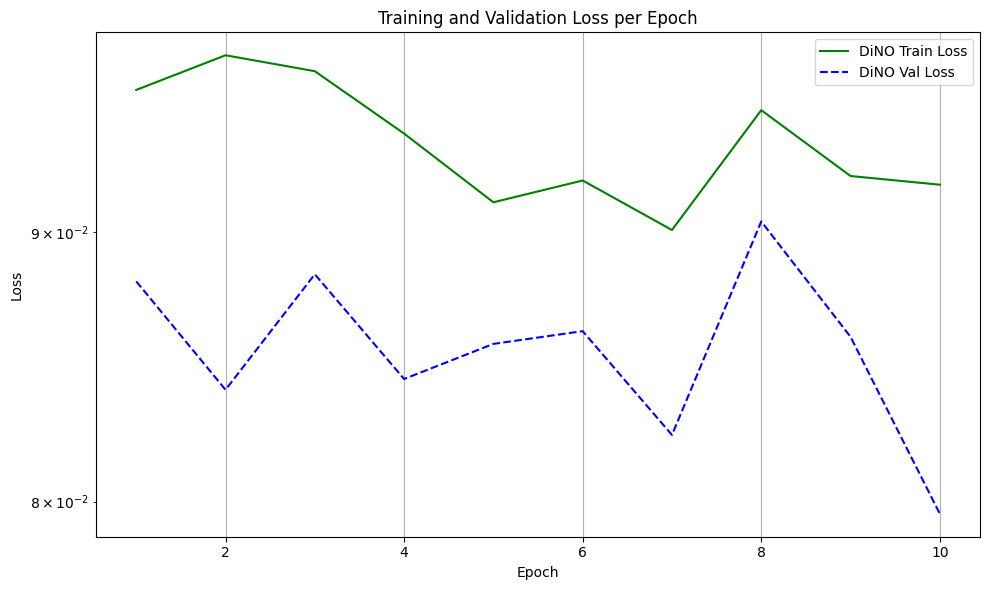

Final training loss: 0.09186892199419137
Final val loss: 0.07957467078488205
Best val loss: 0.07957467078488205, epoch#: 9


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))


plt.plot(epochs, train_loss, label='DiNO Train Loss', color='green', linestyle='-')
plt.plot(epochs, val_loss, label='DiNO Val Loss', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_loss[-1]}')
print(f'Final val loss: {val_loss[-1]}')

best_val_loss = min(val_loss)
best_epoch = val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

#### DINO-Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")

dino_pred = DINOv2Keypoint()
dino_pred.load_state_dict(torch.load("./models/dino.pth"))
calcMSE(dino_pred)

Test Mean Squared Error: 0.1720


# Train your model

# Visualize the model predictions

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


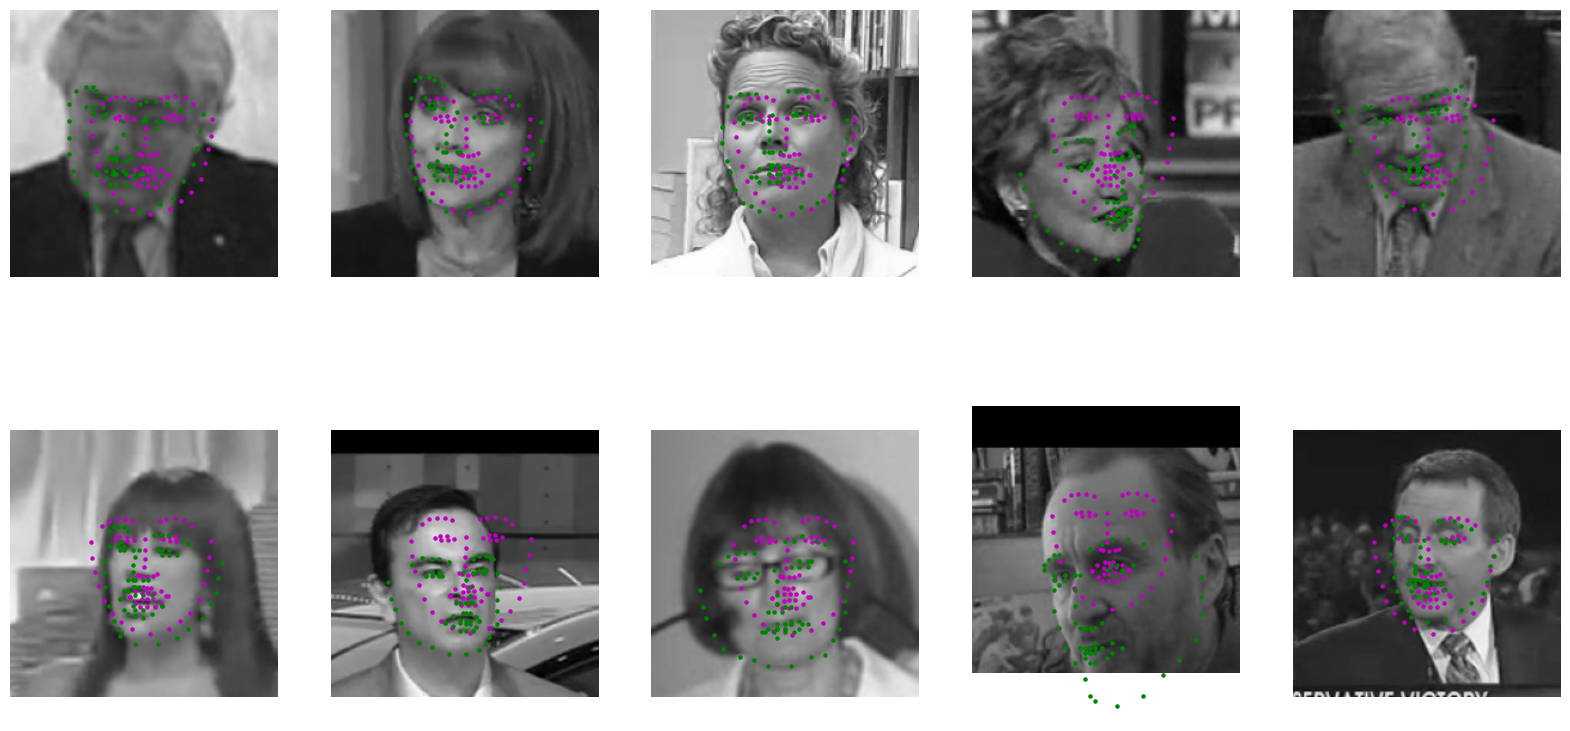

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()



net = dino_pred
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

## Part3-Heatmap Based

### Data Prep

tensor(0.3019) torch.Size([1, 224, 224])


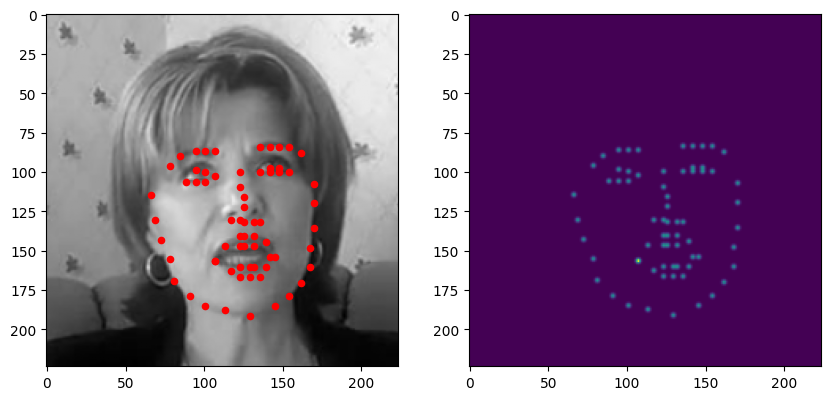

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsHeatmapDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsHeatmapDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
    output_size=224,
    sigma=1
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsHeatmapDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform,
    output_size=224,
    sigma=1
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    # show the heatmaps
    plt.subplot(1, 2, 2)
    heatmaps = sample['heatmaps'][0].sum(dim=0).unsqueeze(0)
    print(heatmaps.max(), sample['heatmaps'][0][0].unsqueeze(0).shape)
    plt.imshow(heatmaps.numpy().transpose(1, 2, 0))
    plt.show()
    break


### Overfit Exercise

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.upconv(x)))


# class Flatten(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pool = nn.AvgPool2d(kernel_size=7)
#         self.activation = nn.GELU()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.activation(self.pool(x)).view(x.size(0), -1)


# class Unflatten(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int):
#         super().__init__()
#         self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=7, stride=7, padding=0)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.activate = nn.GELU()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.view(x.size(0), -1, 1, 1)
#         return self.activate(self.bn(self.convTrans(x)))

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=56, stride=56)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.pool(x)      # (B, C, 1, 1)
        x = self.activation(x)
        return x.view(x.size(0), -1)   # (B, C)

class Unflatten(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=56, stride=56
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x):
        x = x.view(x.size(0), -1, 1, 1)   # (B, in_channels, 1, 1)
        x = self.convTrans(x)            # (B, out_channels, 56, 56)
        return self.activate(self.bn(x))



# Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        return self.conv2(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downConv = DownConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downConv(x)
        return self.conv_block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        return self.conv_block(x)

class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.initial_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens)  # 28x28 -> 14x14
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)  # 14x14 -> 7x7

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2, num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)
        self.last_to_second = ConvBlock(num_hiddens * 2, num_hiddens)
        # self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(num_hiddens, 68, kernel_size=3, padding=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (224, 224), "Expect input shape to be (224, 224)."

        x_init = self.initial_conv(x)
        x1 = self.down1(x_init)
        x2 = self.down2(x1)

        latent = self.flatten(x2)  # (B, num_hiddens*4, 1, 1)
        latent = self.unflatten(latent)  # (B, num_hiddens*4, 7, 7)
        # print("latent_unflattened: ", latent.shape)

        con = torch.cat([latent, x2], dim=1)  # Concatenation with downsampled feature map
        x = self.up2(con)  # (B, num_hiddens*2, 14, 14)


        con = torch.cat([x, x1], dim=1)  # Concatenation with initial feature map
        x = self.up1(con)  # (B, num_hiddens, 28, 28)


        con = torch.cat([x, x_init], dim=1)  # Concatenation with initial feature map
        x = self.last_to_second(con)  # (B, num_hiddens, 28, 28)
        # x = self.final_conv(x)  # Final convolution

        logits = self.final_conv(x)
        # print("logits: ", logits.shape)

        # --- Softmax over spatial dimension ---
        B, C, H, W = logits.shape  # B=Batch, C=68, H=224, W=224
        logits_flat = logits.view(B, C, -1)    # shape (B, 68, 50176)
        # print("logits_flat: ", logits_flat.shape)
        probs_flat = F.softmax(logits_flat, dim=2)
        probs = probs_flat.view(B, C, H, W)    # shape (B, 68, 224, 224)

        return probs

In [ ]:
for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    heatmaps = sample['heatmaps'][0]
    break
# after the break:
image_single   = image.unsqueeze(0)       # shape (1, 1, 224, 224)
heatmaps_single = heatmaps.unsqueeze(0)   # shape (1, 68, 224, 224)

class SingleImageDataset(Dataset):
    def __init__(self, image, heatmaps):
        self.image = image
        self.heatmaps = heatmaps

    def __len__(self):
        return 1  # Only one sample

    def __getitem__(self, idx):
        return {
            "image": self.image[0],       # (1, 224, 224)
            "heatmaps": self.heatmaps[0]  # (68, 224, 224)
        }

# Instantiate it
single_ds = SingleImageDataset(image_single, heatmaps_single)
single_loader = DataLoader(single_ds, batch_size=1, shuffle=False)


model = UnconditionalUNet(in_channels=1, num_hiddens=128)
model = model.to(device)

criterion = nn.MSELoss(reduction='sum')  # or 'mean', but sum often helps
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Overfit on the single image
num_epochs = 500
for epoch in range(num_epochs):
    for batch in single_loader:
        # batch["image"] -> shape (1, 1, 224, 224)
        # batch["heatmaps"] -> shape (1, 68, 224, 224)

        imgs = batch["image"].to(device)
        hmaps = batch["heatmaps"].to(device)

        optimizer.zero_grad()

        outputs = model(imgs)  # (1, 68, 224, 224)
        loss = criterion(outputs, hmaps)
        loss.backward()
        optimizer.step()

    # Print the training loss each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.6f}")


Epoch 1/500 - Loss: 5.409990
Epoch 2/500 - Loss: 5.407088
Epoch 3/500 - Loss: 5.355879
Epoch 4/500 - Loss: 6.925104
Epoch 5/500 - Loss: 6.089769
Epoch 6/500 - Loss: 6.065145
Epoch 7/500 - Loss: 6.040097
Epoch 8/500 - Loss: 5.814856
Epoch 9/500 - Loss: 6.319107
Epoch 10/500 - Loss: 5.646477
Epoch 11/500 - Loss: 5.476830
Epoch 12/500 - Loss: 5.366584
Epoch 13/500 - Loss: 5.349320
Epoch 14/500 - Loss: 5.340129
Epoch 15/500 - Loss: 5.339825
Epoch 16/500 - Loss: 5.335468
Epoch 17/500 - Loss: 5.332915
Epoch 18/500 - Loss: 5.334735
Epoch 19/500 - Loss: 5.332989
Epoch 20/500 - Loss: 5.335927
Epoch 21/500 - Loss: 5.335513
Epoch 22/500 - Loss: 5.328687
Epoch 23/500 - Loss: 5.329909
Epoch 24/500 - Loss: 5.326364
Epoch 25/500 - Loss: 5.321767
Epoch 26/500 - Loss: 5.315243
Epoch 27/500 - Loss: 5.307291
Epoch 28/500 - Loss: 5.310303
Epoch 29/500 - Loss: 5.306600
Epoch 30/500 - Loss: 5.304860
Epoch 31/500 - Loss: 5.301311
Epoch 32/500 - Loss: 5.293950
Epoch 33/500 - Loss: 5.285626
Epoch 34/500 - Loss

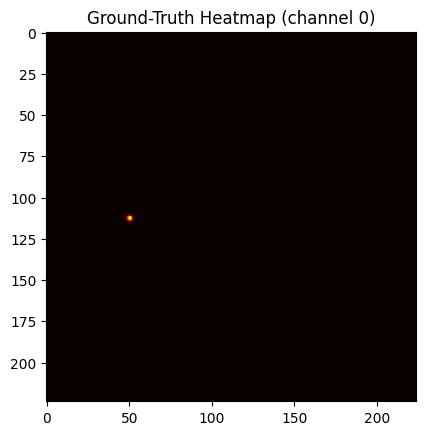

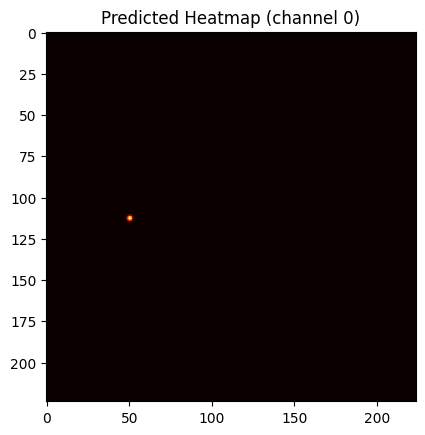

In [ ]:
import matplotlib.pyplot as plt

gt_heatmap = hmaps[0, 0].detach().cpu().numpy()  # channel 0 of shape (224, 224)
plt.imshow(gt_heatmap, cmap='hot')
plt.title("Ground-Truth Heatmap (channel 0)")
plt.show()

model.eval()
with torch.no_grad():
    pred = model(imgs)  # (1, 68, 224, 224)
pred_heatmap = pred[0, 0].cpu().numpy()
plt.imshow(pred_heatmap, cmap='hot')
plt.title("Predicted Heatmap (channel 0)")
plt.show()


### Scale to entire dataet

In [ ]:
# TODO: training code for UNet with heatmaps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from models import UnconditionalUNet
from tqdm import tqdm

# Training loop for U-Net
def train_unet(model, train_loader, val_loader, n_epochs=20, device="cuda", save_path="./models/unet_best.pth"):
    model.to(device)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs), desc="training"):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"epoch {epoch}"):
        # for batch in train_loader:
            images = batch["image"].to(device)  # [B, 1, 224, 224]
            # heatmaps = generate_heatmaps_batch(batch["keypoints"].numpy())  # [B, 68, 64, 64]
            # heatmaps = torch.from_numpy(heatmaps).to(device).float()
            heatmaps = batch["heatmaps"].to(device)  # [B, 68, 224, 224]
            # print(heatmaps.shape)

            optimizer.zero_grad()
            outputs = model(images)
            # print(outputs.shape)
            loss = criterion(outputs, heatmaps)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # avg_train_loss = running_loss / len(train_loader)
        train_losses.append(running_loss)

        val_loss = validate_unet(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f}")
        if epoch in [0, 3, 15, 25]:
            torch.save(model.state_dict(), f'./models/unet_epoch_{epoch}.pth')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'./models/unet_best.pth')
            print("Best model saved.")
    return train_losses, val_losses

# Validation loop
def validate_unet(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            heatmaps = batch["heatmaps"].to(device)
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            val_loss += loss.item()
    model.train()
    return val_loss

model = UnconditionalUNet(
    in_channels=1,
    num_hiddens=128
)
train_losses, val_losses = train_unet(model, train_loader, test_loader, n_epochs=50)

epoch 0: 100%|██████████| 109/109 [02:13<00:00,  1.22s/it]


Epoch 1/25 | Train Loss: 18255.8284 | Val Loss: 4062.7043


training:   4%|▍         | 1/25 [02:46<1:06:47, 166.97s/it]

Best model saved.



epoch 1: 100%|██████████| 109/109 [02:13<00:00,  1.22s/it]


Epoch 2/25 | Train Loss: 16920.0169 | Val Loss: 3835.8849


training:   8%|▊         | 2/25 [05:33<1:03:47, 166.43s/it]

Best model saved.



training:  12%|█▏        | 3/25 [08:15<1:00:23, 164.69s/it]

Epoch 3/25 | Train Loss: 16235.5489 | Val Loss: 3882.0035



epoch 3: 100%|██████████| 109/109 [02:12<00:00,  1.21s/it]


Epoch 4/25 | Train Loss: 15838.2370 | Val Loss: 3684.9181


training:  16%|█▌        | 4/25 [11:01<57:49, 165.23s/it]  

Best model saved.



epoch 4: 100%|██████████| 109/109 [02:12<00:00,  1.22s/it]


Epoch 5/25 | Train Loss: 15531.4387 | Val Loss: 3513.3561


training:  20%|██        | 5/25 [13:46<55:04, 165.25s/it]

Best model saved.



epoch 5: 100%|██████████| 109/109 [02:12<00:00,  1.21s/it]


Epoch 6/25 | Train Loss: 15295.1206 | Val Loss: 3483.6194


training:  24%|██▍       | 6/25 [16:31<52:15, 165.04s/it]

Best model saved.



epoch 6: 100%|██████████| 109/109 [02:12<00:00,  1.22s/it]


Epoch 7/25 | Train Loss: 15099.4453 | Val Loss: 3449.1966


training:  28%|██▊       | 7/25 [19:16<49:29, 164.98s/it]

Best model saved.



training:  32%|███▏      | 8/25 [21:58<46:30, 164.12s/it]

Epoch 8/25 | Train Loss: 14884.2772 | Val Loss: 3483.9551



training:  36%|███▌      | 9/25 [24:41<43:41, 163.82s/it]

Epoch 9/25 | Train Loss: 14711.6753 | Val Loss: 3559.9589



training:  40%|████      | 10/25 [27:24<40:51, 163.43s/it]

Epoch 10/25 | Train Loss: 14552.2899 | Val Loss: 3666.0721



epoch 10: 100%|██████████| 109/109 [02:12<00:00,  1.21s/it]


Epoch 11/25 | Train Loss: 14346.1652 | Val Loss: 3416.9830


training:  44%|████▍     | 11/25 [30:09<38:13, 163.80s/it]

Best model saved.



epoch 11: 100%|██████████| 109/109 [02:12<00:00,  1.21s/it]


Epoch 12/25 | Train Loss: 14163.9002 | Val Loss: 3380.2597


training:  48%|████▊     | 12/25 [32:53<35:33, 164.09s/it]

Best model saved.



training:  52%|█████▏    | 13/25 [35:36<32:42, 163.56s/it]

Epoch 13/25 | Train Loss: 13993.3932 | Val Loss: 3436.0893



training:  56%|█████▌    | 14/25 [38:18<29:54, 163.11s/it]

Epoch 14/25 | Train Loss: 13833.2080 | Val Loss: 3707.5395



training:  60%|██████    | 15/25 [41:01<27:11, 163.13s/it]

Epoch 15/25 | Train Loss: 13639.8036 | Val Loss: 3434.6332



epoch 15: 100%|██████████| 109/109 [02:13<00:00,  1.22s/it]


Epoch 16/25 | Train Loss: 13445.4379 | Val Loss: 3662.2420


training:  68%|██████▊   | 17/25 [46:29<21:48, 163.57s/it]

Epoch 17/25 | Train Loss: 13286.1771 | Val Loss: 3523.1761



training:  72%|███████▏  | 18/25 [49:12<19:02, 163.28s/it]

Epoch 18/25 | Train Loss: 13068.8721 | Val Loss: 3534.9614



training:  76%|███████▌  | 19/25 [51:55<16:20, 163.34s/it]

Epoch 19/25 | Train Loss: 12879.0844 | Val Loss: 3676.0950



training:  80%|████████  | 20/25 [54:39<13:36, 163.26s/it]

Epoch 20/25 | Train Loss: 12711.8524 | Val Loss: 3486.4798



training:  84%|████████▍ | 21/25 [57:21<10:51, 162.95s/it]

Epoch 21/25 | Train Loss: 12550.0864 | Val Loss: 3449.2819



training:  88%|████████▊ | 22/25 [1:00:04<08:08, 162.98s/it]

Epoch 22/25 | Train Loss: 12347.1645 | Val Loss: 3694.7453



training:  92%|█████████▏| 23/25 [1:02:47<05:25, 162.95s/it]

Epoch 23/25 | Train Loss: 12167.4720 | Val Loss: 3712.8226



training:  96%|█████████▌| 24/25 [1:05:30<02:43, 163.07s/it]

Epoch 24/25 | Train Loss: 11995.0962 | Val Loss: 3520.2721



training: 100%|██████████| 25/25 [1:08:13<00:00, 163.73s/it]

Epoch 25/25 | Train Loss: 11821.8318 | Val Loss: 3670.0451


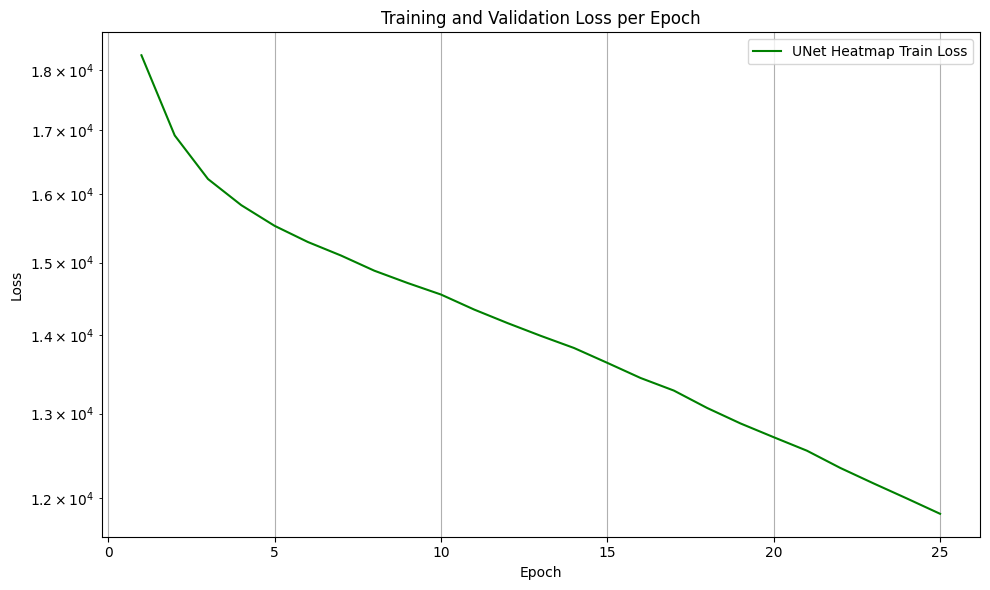

Final training loss: 11821.831798553467
Final val loss: 3670.045090675354
Best val loss: 3380.259711265564, epoch#: 11


In [ ]:
# loss viz
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))


plt.plot(epochs, train_losses, label='UNet Heatmap Train Loss', color='green', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_losses[-1]}')
print(f'Final val loss: {val_losses[-1]}')

best_val_loss = min(val_losses)
best_epoch = val_losses.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

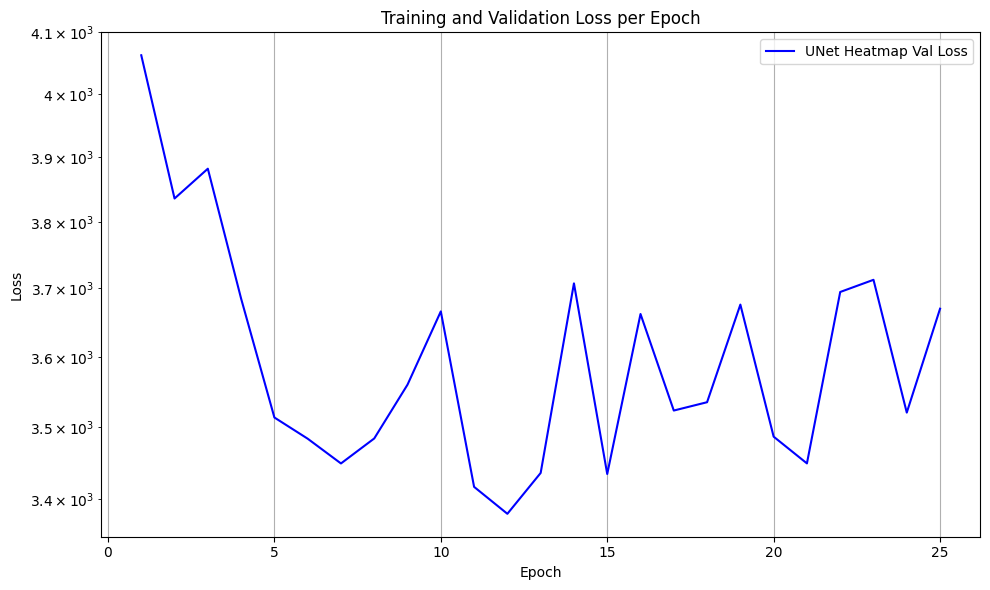

Final training loss: 11821.831798553467
Final val loss: 3670.045090675354
Best val loss: 3380.259711265564, epoch#: 11


In [ ]:
# loss viz
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))


plt.plot(epochs, val_losses, label='UNet Heatmap Val Loss', color='blue', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_losses[-1]}')
print(f'Final val loss: {val_losses[-1]}')

best_val_loss = min(val_losses)
best_epoch = val_losses.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

[36 66]


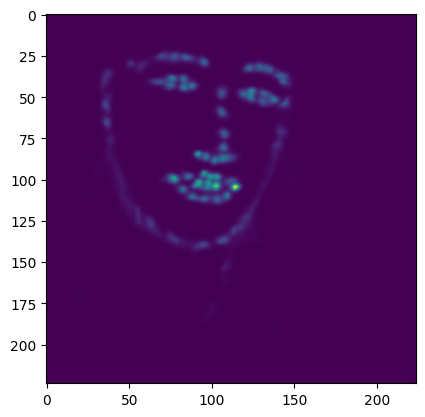

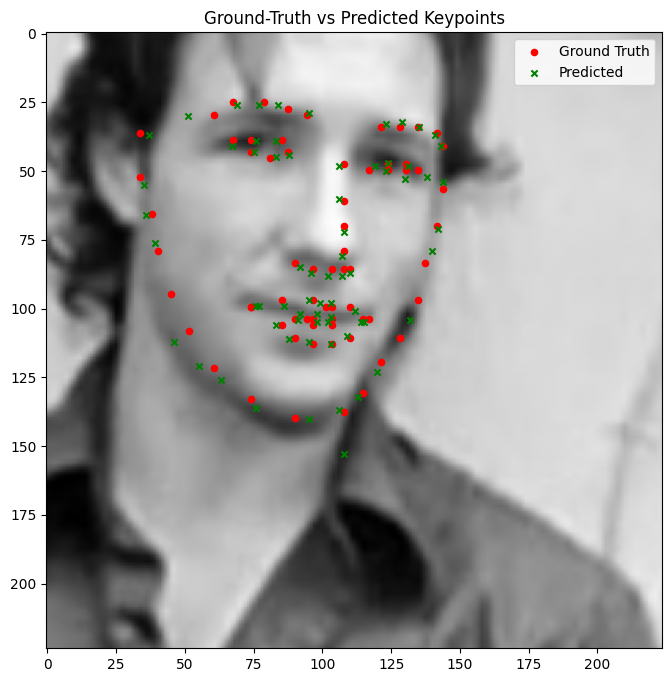

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnconditionalUNet(
    in_channels=1,
    num_hiddens=128
)
model.load_state_dict(torch.load("./models/unet_best.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    for i, sample in enumerate(test_loader):
        # 2) Move input images to GPU (if available)
        images_gpu = sample['image'].to(device)      # Shape [B, 1, 224, 224]

        # 3) Run inference -> predicted heatmaps
        pred_heatmaps = model(images_gpu)            # Shape [B, K, 224, 224]
        # print(pred_heatmaps[0][0].sum())
        heatmaps = pred_heatmaps[0].sum(dim=0, keepdim=True)
        plt.imshow(heatmaps.cpu().numpy().transpose(1, 2, 0))

        # Ground-truth keypoints (still on CPU)
        # Shape [B, K, 2], might be normalized or partially scaled
        gt_keypoints = sample['keypoints']

        # We'll visualize the first image in this batch
        b = 0

        # -- Prepare the raw image for plotting --
        image_np = sample['image'][b].numpy().transpose(1, 2, 0)  # shape (224, 224, 1)
        image_np = image_np.squeeze()  # -> shape (224, 224)

        # -- Ground-Truth Keypoints --
        # If your dataset keypoints are in some normalized form, apply the same
        # scaling/shift you used in your original snippet (*50 + 100).
        gt_kps = gt_keypoints[b].numpy()  # shape [K, 2]
        gt_x = gt_kps[:, 0] * 50 + 100
        gt_y = gt_kps[:, 1] * 50 + 100

        # -- Predicted Keypoints (Argmax in each heatmap) --
        pred_kps = []
        heatmaps_b = pred_heatmaps[b]  # shape [K, 224, 224]
        K = heatmaps_b.shape[0]

        for k in range(K):

            max_val = heatmaps_b[k].max()
            flat_idx = torch.argmax(heatmaps_b[k])
            row = flat_idx // 224
            col = flat_idx % 224
            pred_kps.append([col.item(), row.item()])

        pred_kps = np.array(pred_kps)  # shape [K, 2]
        print((pred_kps[2]))

        # -- Visualization --
        plt.figure(figsize=(8, 8))
        plt.imshow(image_np, cmap="gray")

        # Plot ground-truth keypoints (red)
        plt.scatter(gt_x, gt_y, c='r', s=20, label='Ground Truth')
        # Plot predicted keypoints (green 'x')
        plt.scatter(pred_kps[:, 0], pred_kps[:, 1], c='g', marker='x', s=20, label='Predicted')

        plt.title("Ground-Truth vs Predicted Keypoints")
        plt.legend()
        plt.show()

        # Stop after visualizing the first batch
        break


In [ ]:
import torch
import torch.nn.functional as F

def heatmaps_to_keypoints_argmax(heatmaps):
    """
    heatmaps: (B, 68, H, W)
    returns keypoints_pred: (B, 68, 2) in pixel space (y, x).
    """
    B, K, H, W = heatmaps.shape

    # Flatten spatial dimensions
    # shape: (B, 68, H*W)
    heatmaps_flat = heatmaps.view(B, K, -1)

    # Argmax over spatial dimension -> index in [0..(H*W - 1)]
    max_indices = heatmaps_flat.argmax(dim=2)  # shape: (B, 68)

    # Convert linear indices to (row, col)
    row_coords = max_indices // W
    col_coords = max_indices % W

    # Stack them to get shape (B, 68, 2)
    # Typically we treat (row, col) = (y, x)
    keypoints_pred = torch.stack([col_coords, row_coords], dim=2).float()

    return keypoints_pred  # (B, 68, 2)

model = UnconditionalUNet(
    in_channels=1,
    num_hiddens=128
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load("./models/unet_best.pth"))
model.to(device)
model.eval()
mse_criterion = nn.MSELoss()
total_loss = 0.0
count = 0

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)          # (B,1,H,W)
        gt_heatmaps = batch["heatmaps"].to(device) # (B,68,H,W)
        gt_keypoints = batch["keypoints"].to(device) # (B,68,2) in pixel space or normalized?


        # 1) Predict heatmaps
        pred_heatmaps = model(imgs)  # (B, 68, H, W)

        # 2) Convert heatmaps -> keypoints
        pred_keypoints = heatmaps_to_keypoints_argmax(pred_heatmaps)
        pred_keypoints = (pred_keypoints - 100.0) / 50.0
        # print(pred_keypoints.shape)

        # 4) Flatten for MSE or do elementwise
        pred_keypoints_flat = pred_keypoints.view(pred_keypoints.size(0), -1)
        gt_keypoints_flat   = gt_keypoints.view(gt_keypoints.size(0), -1)

        # 5) Compute MSE
        loss = mse_criterion(pred_keypoints_flat, gt_keypoints_flat)

        total_loss += loss.item()

mean_mse = total_loss / len(test_loader)
print(count)
print("Mean MSE (Keypoints):", mean_mse)




0
Mean MSE (Keypoints): 0.0445143293706953
